# <center>Дипломная работа DST-1024
# <center>Модель прогнозирования стоимости жилья</center>  
# <center>для агентства недвижимости</center>  



# 1. Постановка задачи

## Описание проекта  
помочь агентству недвижимости увеличить прибыль за счет устраниние следующей проблемы: сократить время сортировки объявлений и поиска выгодных предложений. Увеличив скорость отклика и качество анализа данных на рынке недвижимости увеличить финансовую составляющую организации.

## Бизнес-задачa  
необходимо разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

## Основные цели проекта:
1. Произвести очистку и разведывательный анализ набора реальных данных (обработать пропуски, дубликаты и выбросы, устранить ошибки ввода, расшифровать сокращения, отыскать закономерности, сгенерировать новые признаки с использованием внешних источников).
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.  
3. Построить модель для прогнозирования стоимости недвижимости.  
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

# 2. Описание данных 

Описание признаков в датафрейме:  
- 'status' — статус продажи;  
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;  
- 'propertyType' — тип объекта недвижимости;
-  'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [3]:
#импорт библиотек
import pandas as pd
import numpy as np

import sweetviz as sv

import seaborn as sns
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup
import requests

import category_encoders as ce
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from catboost import Pool, CatBoostRegressor
import optuna
import pickle

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Читаем файл с данными и выводим первые три строки
df = pd.read_csv('data.csv')
df.head(3)

status private pool        propertyType             street    baths  \
0    Active          NaN  Single Family Home     240 Heather Ln      3.5   
1  for sale          NaN  single-family home  12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home  2005 Westridge Rd  2 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000

In [5]:
# Вывод основной информации о даных
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

None

status private pool        propertyType                 street  \
count     337267         4181              342452                 377183   
unique       159            1                1280                 337076   
top     for sale          Yes  single-family home  Address Not Disclosed   
freq      156104         4181               92206                    672   

          baths                                          homeFacts fireplace  \
count    270847                                             377185    103115   
unique      229                                             321009      1653   
top     2 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...       yes   
freq      52466                                               7174     50356   

           city                                            schools    sqft  \
count    377151                                             377185  336608   
unique     2026                                             297365   25405   
top     Houston  [{'rating': [], 'data': {'Distance': [], 'Grad...       0   
freq      24442                                               4204   11854   

       zipcode    beds   state stories   mls-id PrivatePool   MlsId    target  
count   377185  285903  377185  226470    24942       40311  310305    374704  
unique    4549    1184      39     348    24907           2  232944     43939  
top      32137  3 Beds      FL     1.0  No MLS#         yes  NO MLS  $225,000  
freq      2141   53459  115449   67454        3       28793      24      1462

                                             |          | [  0%]   00:00 -> (? left)


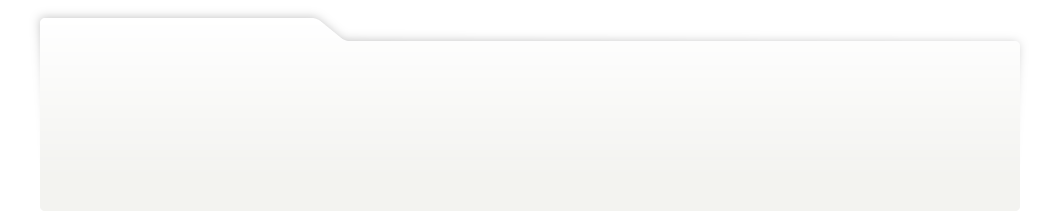
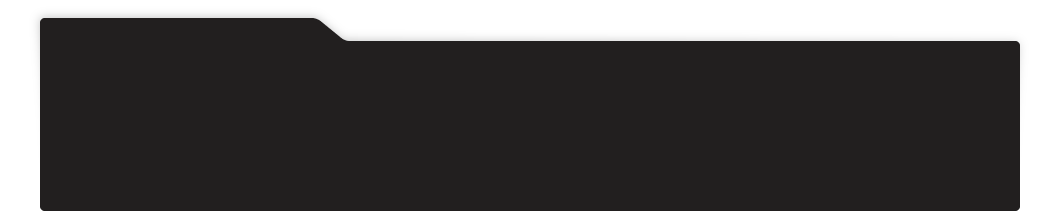
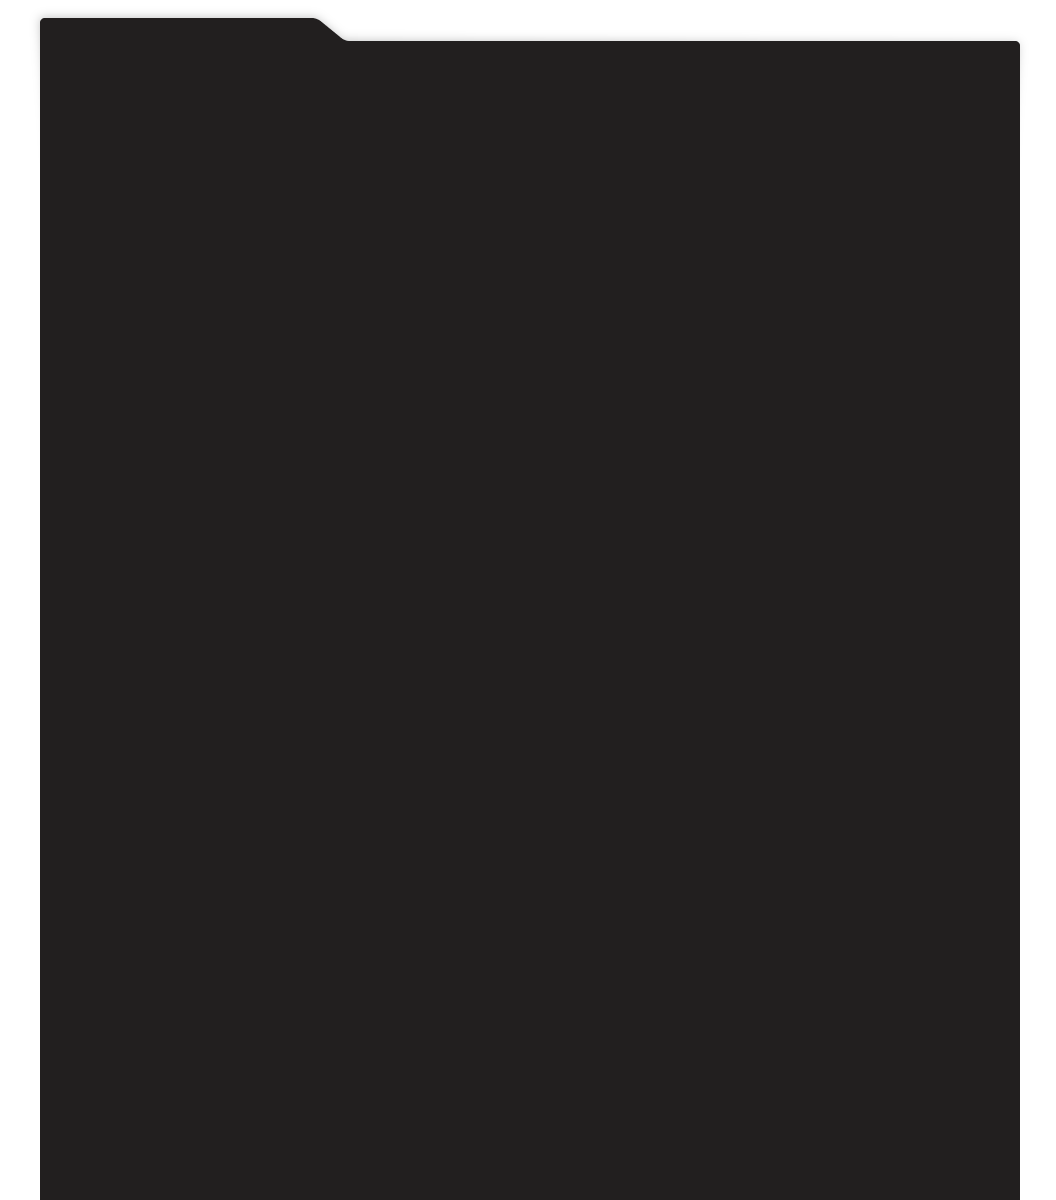
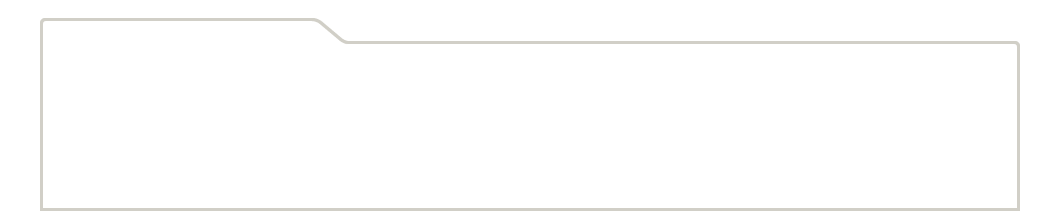
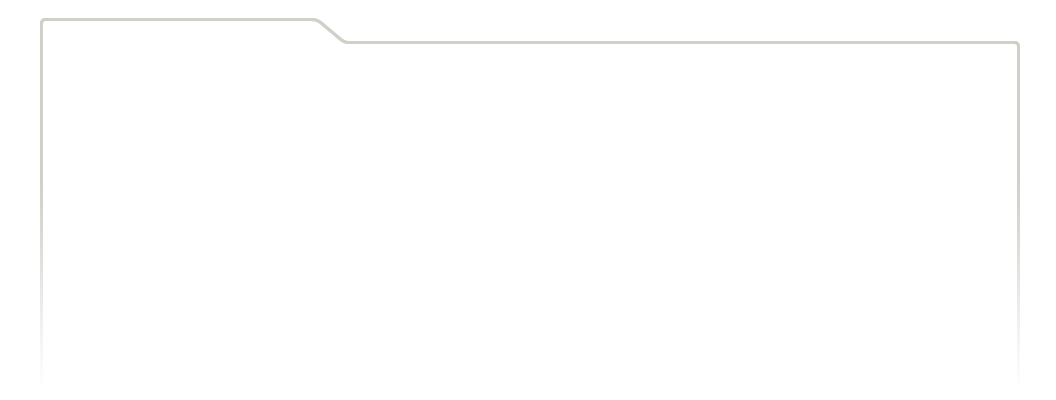
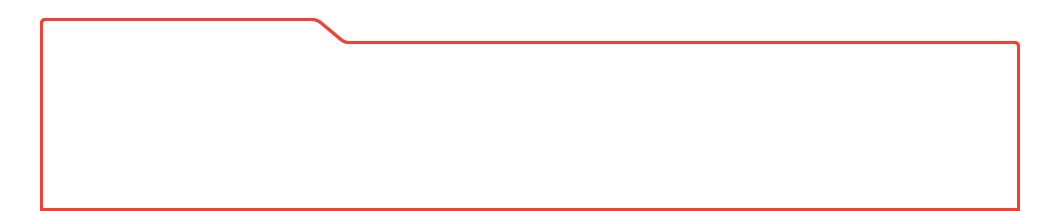
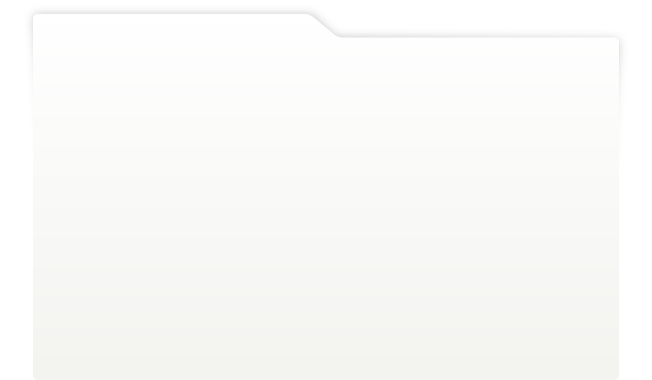
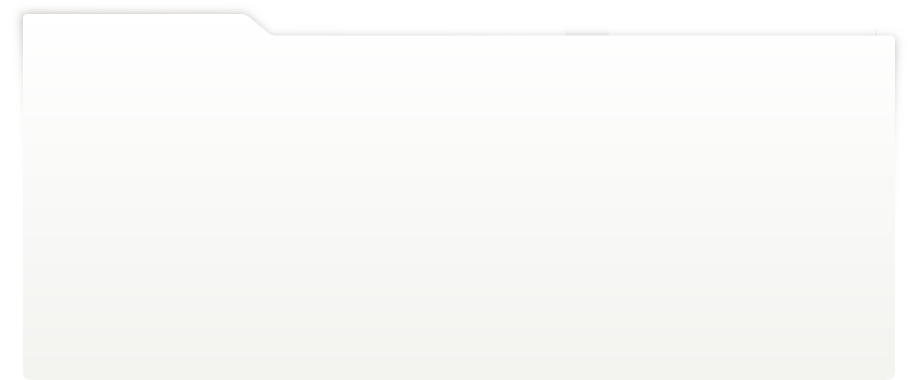
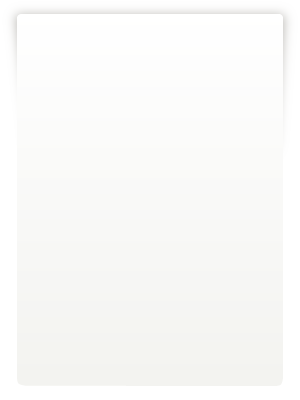
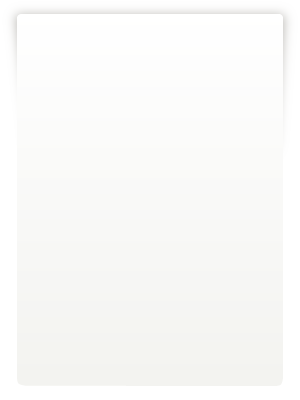
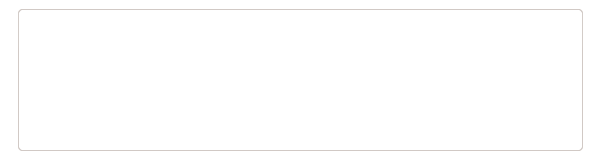
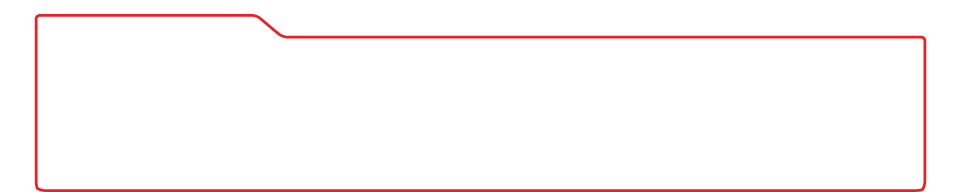
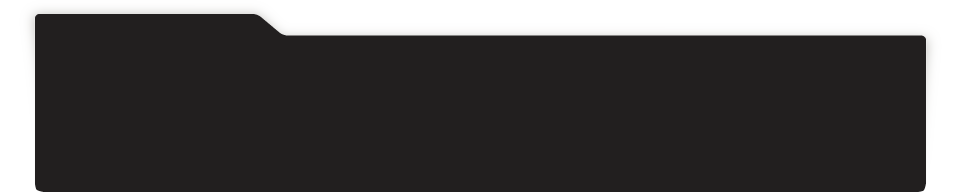
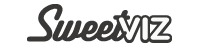
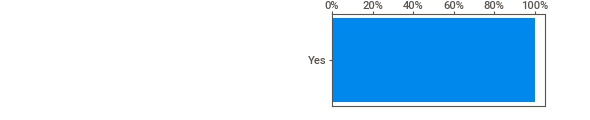
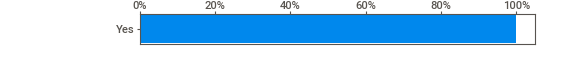
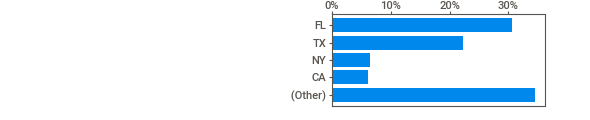
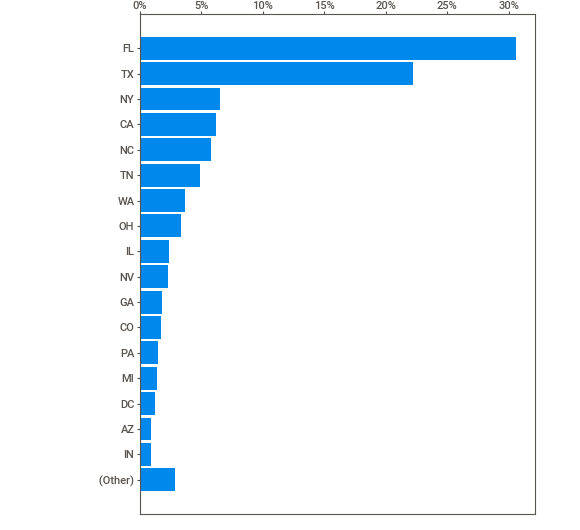
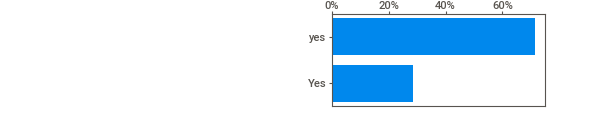
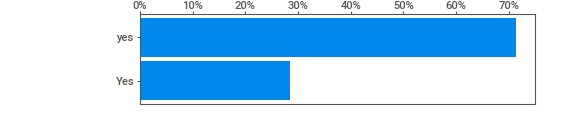
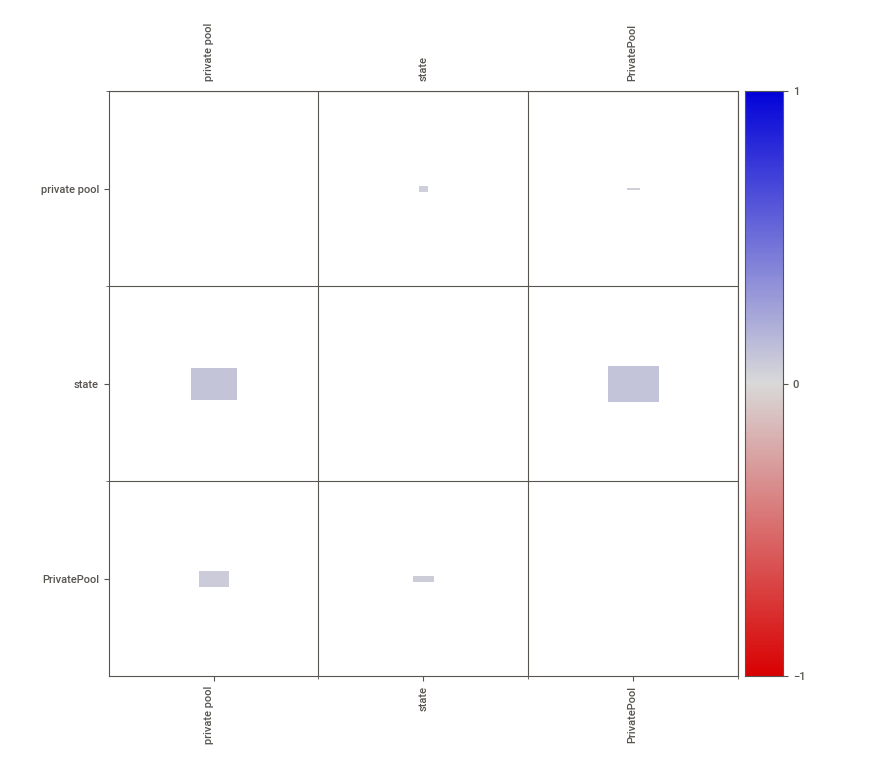
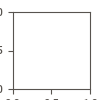

ERROR: comet_ml is installed, but not configured properly (e.g. check API key setup). HTML reports will not be uploaded.


In [6]:
# Осуществляем разведывательный анализ данных, используя библиотеку SweetViz
report = sv.analyze(df)
report.show_notebook(scale=0.95)

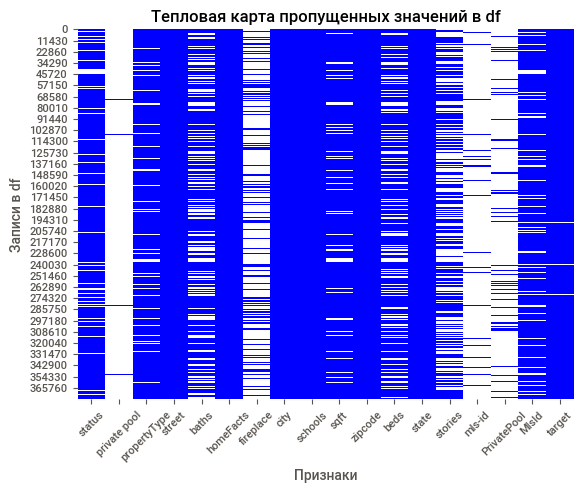

In [7]:
# Тепловая карта отразит пропущенные значения
heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['blue', 'white']),
    cbar = False
);
heatmap.set_title('Тепловая карта пропущенных значений в df');
heatmap.set_xlabel('Признаки');
heatmap.set_ylabel('Записи в df');
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

Вывод знакомства с данными: 
1. В имеющихся данных содержится большое количество пропусков:  
    1.1. Признак "наличие собственного бассейна", состоящий из двух столбцов "private pool" и "PrivatePool" содержит 99% и 89% пропусков. Даже объединив их, процент пропусков будет высок, поэтому этот признак необходимо исключить - необходимо проверить данную гипотезу.  
    1.2. Признак "наличие камина" "fireplace" - 73% пустых значений, поэтому этот признак необходимо исключить.  
    1.3. Признак мультилистинга "msl-id" содержит 93% пропусков, дублирующий его "MlsId" - 18%, возможно при объединении этих столбцов количество пропусков станет адекватным. Но, принимая во внимание, что в признаке соединены город, штат и почтовый индекс объекта, то есть данные, уже имеющиеся в df отдельно, логично будет удалить оба признака.  
    1.4. Целевой признак "target" содержит 2 481 пустую запись. Мы удалим эти записи, чтобы они не мешали обучению модели.
2. Количество полных дубликатов = 50 их тоже следует удалить.  
3. Признаки с высоким процентом уникальных значений - категория неинформативных данных:  
    3.1. Признак "улица" "street" - 89%. содержит порядка 40 тыс. одинаковых названий (улица и номер дома например). Это означает, что либо объявление публиковалось несколько раз, либо это несколько домов, расположенных на одной улице, либо участки, на которых возвели или снесли дома. Иными словами, дубликаты, которые требуется удалить.   
    3.2. Признак "школа в районе" "schools" - 79%. Из этого признака перед удалением можно получить информацию о школах рядом с объектами недвижимости.
    3.3. Признак "сведения о строительстве""homeFacts" - 85%. Из этого признака перед удалением можно получить информацию о годах постройки, наличия\отсутствия отопления и кондиционера, парковки, площади участка и стоимости за квадрат. 
4. Другие признаки:  
    4.1. Признак "город" "city" - 2009 уникальных названий городов. В данном признаке необходимо удалить пустые значения и выделить среди всех названий столицы штата, т.к. цена на недвижимость в них будет определенно больше чем в небольших городах штата.  
    4.2. Признак "почтовый индекс" "zipcode" - перед удалением используем этот признак при обработке признака "city".  

___

## 3. Предобработка и очистка данных 
  

In [8]:
# Просматриваем размерность до предобработки
print('Размерность df до предобработки:', df.shape)
rows = df.shape[0]
cols = df.shape[1]

#удаление ненужных признаков, строк, дубликатов
df.drop(['mls-id', 'MlsId', 'fireplace'], axis=1, inplace=True)
df.dropna(axis=0, subset='target', inplace=True) 
df.dropna(axis=0, subset='city', inplace=True)
df.drop_duplicates(inplace=True)

print('Размерность df после предобработки:', df.shape)
print(f'Удалено: {rows-df.shape[0]} строки и {cols-df.shape[1]} столбца')

Размерность df до предобработки: (377185, 18)
Размерность df после предобработки: (374532, 15)
Удалено: 2653 строки и 3 столбца


### 3.1. Обработка признака "статус продажи" "status"  

In [9]:
# Выделим категории, имеющие выше 1%
status = df['status'].value_counts(normalize=True)*100
display('Доли категорий собственности в df (%):', round(status[status > 1],2))

'Доли категорий собственности в df (%):'

for sale            46.54
Active              31.35
For sale            12.96
foreclosure          1.69
New construction     1.63
Pending              1.40
Name: status, dtype: float64

1) Видим , что основные категории это "Active" и "For Sale", к объединению, т.к. смысл более или менее одинаков.    

2) Объединим таким же образом категории:
- "Foreclosure"и "Auction" - объекты попавшие под аукцион или лишеные права выкупа; 
- "New construction" и "Pending" - все возможные случаи, в которых оформление сделки началось, но приостановилось , сюда же добавим все разновидности "Contingency".
- "New" объединим с "Coming soon <дата сдачи>".  
3) "Rent" (в количестве 412) подлежит удалению, т.к. целевой признак для такого типа указан за месяц и не имеет практической ценности для модели.    

Итоговые выделенные группы:  
- Active,  
- Foreclosure,  
- Pending,
- New.   

Остальные статусы и пустые значения статуса - категория "Other".  

In [10]:
# Функция, которая объединят схожие значения в признаке
def find_fill(fill_value: str,
              find_value: list,
              feature: str,
              df: pd.DataFrame = df) -> pd.DataFrame:
    """Функция объединяет в одну группу fill_value похожие
    значения find_value в признаке feature и возвращает
    обновленный df.

    Args:
        fill_value (str): общее название группы
        find_value (list): похожие значения для объединения
        feature (str): названия признака, где происходит поиск
        df (pd.DataFrame, optional): датафрейм, по умолчанию = df

    Returns:
        pd.DataFrame: обновленный датафрейм
    """

    # множество для хранения индексов строк
    ind = set()
    # Запускаем цикл по всем значениям признака, которые нужно найти в ячейках
    for value in find_value:
        # Добавляем ко множеству индексы всех строк с искомым значением value
        ind.update(df[df[feature].str.contains(value, case=False) == True].index)
    # Заменяем все значения по найденным индексам на общее значение
    df.loc[list(ind), feature] = fill_value

    del ind # очищаем память

    # обновленный df
    return df


In [11]:
# Создадим словарь из часто встречающихся cтатусов продажи;
# в качестве значений укажем типы для группировки
status_type = {
    'Foreclosure': ['auction', 'foreclo'],
    'Pending': ['continge', 'pend'],
    'New': ['new', 'coming'],
    'Active': ['active', 'sale']
}

# Запускаем цикл по всем элементам словаря статусов продажи.
# В написанную фукцию будем распаковывать ключ и значения словаря
# для первых двух параметров, затем название признака и сам датафрейм
for s in status_type.items():
    df = find_fill(*s, 'status', df)

# Добавим к статусу Pending некоторые записи вручную. Они зашифрованы дной или несколькими буквами, поэтому требуют применения метода fullmatch
# Создаем список для хранения индексов строк
ind = []
ind.extend(list(df[df['status'].str.fullmatch('C') == True].index))
ind.extend(list(df[df['status'].str.fullmatch('P') == True].index))
ind.extend(list(df[df['status'].str.fullmatch(r'P[s,f,i]') == True].index))
df.loc[ind, 'status'] = 'Pending'

# Удалем объявления со статусом аренды
ind = df[df['status'].str.contains('rent', case=False) == True].index
df.drop(ind, axis=0, inplace=True)

# Всем оставшимся категориям присвоим статус Other
mask = df['status'].isin(status_type.keys()) # сформируем маску из 4-х основных статусов
df.loc[df[~mask].index, 'status'] = 'Other' # всем остальным статусам присвоим Other

# удалим переменные
del status_type, ind, mask 

### 3.2. Обработка признака "private pool"   

In [12]:
# Создадим фильтры пустых значений
mask1 = df['private pool'].isna() == True
mask2 = df['PrivatePool'].isna() == True
share = round(df[mask1 & mask2].shape[0] / df.shape[0] * 100, 2)
print(f'Доля пустых значений статуса бассейн: {share}%')

del mask1, mask2, share

Доля пустых значений статуса бассейн: 88.19%


Проверка гипотезы: после объединения, доля пропущенных значений приближается примерно 90% - данный признак подлежит удалению

In [13]:
# Удаляем признаки
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

### 3.3. Обработка признака  "количество этажей" "stories" 

Т.к. в признаке "propertyType" содержится количество этажей, которое отсутствует в признаке "stories" необходимо перенести информацию о количестве этажей из "propertyType" в "stories".  
Далее займемся обработкой значений, которые будут находиться в признаке "stories", включая пустые.  

In [14]:
# Функция для выделения числа этажей
def story_num(s: str) -> str:
    """Функция принимает на вход строку и выделяет из нее
    количество этажей. Возвращает это количество или NaN,
    если оно не было в строке.

    Функция возвращает число этажей в формате строки, т.к.
    часто встречаются буквенные обозначения: "One Story".

    Например (исх. строка -> результат работы функции):
    - '1 Story' -> '1'
    - 'Detached, Two Story' -> 'Two'
    - 'Low-Rise (1-3 Stories)' -> '3'
    - 'Historical -> NaN

    Args:
        s (str): строка с количеством этажей из признака propertyType

    Returns:
        str: количество этажей в формате строки
    """

    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'(\w+)\+*\s[Sstor]', s) # выделяем число этажей
        if len(result) > 0:
            result = result[0] # если этаж был во входной строке, сохраняем его в формате строки
        else:
            result = np.NaN # если этажа не было, вернем NaN

    # Возвращаем результат в виде строки или float, если это NaN
    return result

In [15]:
# Сохраняем часть df, где вместо типа жилья указаны этажи (7.7+ тыс. объектов)
df_story = df[df['propertyType'].str.contains('stor', case=False) == True]
# Из этой таблицы выбираем те, у которых пустой признак stories, сохраняем индексы
story_ind = df_story[df_story['stories'].isna() == True].index
# В главном df по сохраненному индексу заполняем пропуски в признаке stories
# Используем для этого написанную функцию
df.loc[story_ind, 'stories'] = df.loc[story_ind, 'propertyType'].apply(lambda s: story_num(s))

# удаляем ненужные переменные
del df_story, story_ind 

В признаке "propertyType" есть указание на высоту объекта недвижимости: Low Rise (1-3 этажа), Mid Rise (4-7 этажей), High Rise (от 8 этажей и выше), используем это  для заполнения пропущенных значений в признаке "stories". Для этого напишем функцию, которую применим для каждой разновидности объектов.

In [16]:
# Функция для заполнения пустых значений в признаке на основе другого признака
def find_fillna(source_feature: str,
                target_feature: str,
                find_value: str,
                fill_value: str,
                df: pd.DataFrame = df) -> pd.DataFrame:
    """Функция получает на вход название признака source_feature,
    в котором требуется искать find_value, затем в признаке
    target_feature отыскивает пустые значения и заполняет их
    с помощью fill_value. Все изменения производятся в переданном
    в функцию df, который и возвращается обновленным.

    Args:
        source_feature (str): признак, где производится поиск значения find_value
        target_feature (str): признак, где заполняются пустые значения
        find_value (str): значение для поиска в source_feature
        fill_value (str): значение для заполнения пропусков в target_feature
        df (pd.DataFrame, optional): df, по умолчанию = df

    Returns:
        pd.DataFrame: обновленный df
    """

    #  Сохраняем часть df, где в признаке source_feature указано find_value
    df_story = df[df[source_feature].str.contains(find_value, case=False) == True]
    # Из этой таблицы выбираем те строки, в которых пустой признак target_feature
    story_ind = df_story[df_story[target_feature].isna() == True].index
    # В главном датафрейме заполняем пропуски в признаке target_feature на значение fill_value
    df.loc[story_ind, target_feature] = fill_value

    del df_story, story_ind # освобождаем память

    #  обновленный df
    return df

In [17]:
# Применим написанную выше функцию для каждого из трех видов высоты объекта
df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'Low.Rise',
    fill_value = 'Low Rise (1-3 Stories)',
    df = df
)

df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'Mid.Rise',
    fill_value = 'Mid Rise (4-7 Stories)',
    df = df
)

df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'High.Rise',
    fill_value = 'High Rise (8+ Stories)',
    df = df
)

### 3.4. Обработка признака "propertyType"  

"Single family" - отдельно стоящий дом для одной семьи. Отнесем к этому типу все стили архитектуры: "Cape Cod", "Colonial", "Farmhouse" и т.д. 

Соответсвующим образом выделим жилье для нескольких семей ("Multifamily"): это может быть как отдельно стоящий дом, так и часть в комплексе "Townhouse".  

Соответсвующим образом выделим жилье "Townhouse" - дом для одной семьи,  одной стеной примыкающий к другому дому. Наличие соседей сразу за стеной вероятно может влиять на стоимость.  

Соответсвующим образом выделим жилье "Condo" - квартиры, их более 51 тыс, соединим их с типом "Apartment" (813 шт), а также добавим "Coop" - квартиры в жилищных кооперативах.

Соответсвующим образом выделим тип "lot / land" - пустые участки земли, обозначим их "Land".  

Все остальные объекты относим к самому популярному типу - "Single famile" (включая гаражные постройки).  

Используем функцию find_fill() из пункта 3.1., она обнаружит типы жилья и заменит их на название группы. После ее применения остальное вручную отнесем к первой группе.  

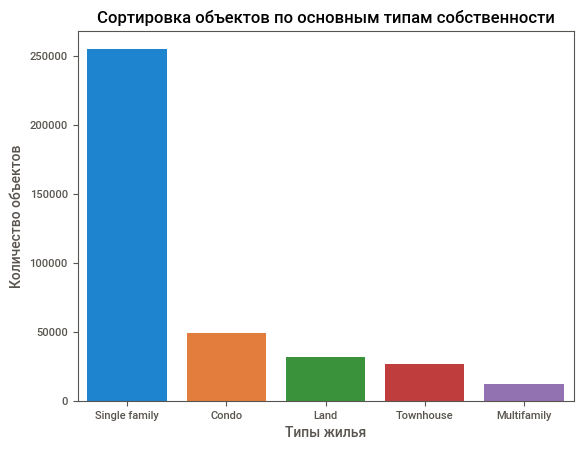

In [18]:
# Создадим словарь из отдельных типов недвижимости; в качестве значений укажем типы для группировки
proper_type = {
    'Single family': ['single', 'bunga', 'cluster', 'colon', 'cape',
                      'contemp', 'cottage', 'craft', 'farm', 'federal',
                      'french', 'feder', 'florida', 'garden', 'historic',
                      'mediter', 'mobile', 'other', 'ranch', 'spanish',
                      'split', 'tradit', 'transit', 'tudor', 'victor',
                      'Low.Rise', '1 Sto', 'One Sto', '2 Sto', 'Two Sto'],
    'Multifamily': ['multi'],
    'Townhouse': ['town', 'co-op'],
    'Condo': ['condo', 'apart', 'coop', 'Mid.Rise', 'High.Rise'],
    'Land': ['land', 'lot']
}

# запустим цикл по всем элементам словаря типов недвижимости
# В фукцию find_fill() будем распаковывать ключ и значения словаря
# для первых двух параметров, затем название признака и сам df
for p in proper_type.items():
    df = find_fill(*p, 'propertyType', df)

# Оставшиеся типы недвижимости заменим на Single family
# Для этого сначала сохраним ключи словаря в список
main_types = list(proper_type.keys())

# Создадим маски по основным типам объектов
mask1 = df['propertyType'] == main_types[0]
mask2 = df['propertyType'] == main_types[1]
mask3 = df['propertyType'] == main_types[2]
mask4 = df['propertyType'] == main_types[3]
mask5 = df['propertyType'] == main_types[4]

# Выберем индексы записей из df, которые не относятся к 5 типам
left_ind = df[~mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5].index

# Присвоим им самый популярный тип - Single family
df.loc[left_ind, 'propertyType'] = main_types[0]

# Проверим, что все типы недвижимости разошлись по пяти группам
barplot = sns.barplot(
    data = df['propertyType'].value_counts().to_frame().reset_index(),
    y = 'propertyType',
    x = 'index'
);
barplot.set_title('Сортировка объектов по основным типам собственности');
barplot.set_xlabel('Типы жилья');
barplot.set_ylabel('Количество объектов');

### 3.5. Дальнейшая обработка "stories"  

Заполним пропуски с помощью данных, которые сохранились в признаке "propertyType". Число этажей поделим на группы:  
- Single family - Low Rise (1-3 Stories),  
- Multifamily - Low Rise (1-3 Stories),  
- Townhouse - Low Rise (1-3 Stories),  
- Condo - Low Rise (1-3 Stories), Mid Rise (4-7 Stories), High Rise (8+ Stories),  
- Land - 0 Stories.  

Так как только квартиры могут располагаться на разных этажах и это может влиять на стоимость жилья, сохраним такое разделение у квартир. Сначала прицельно обработаем записи для "Condo". Если есть указание на этаж квартиры,  сохраним его и отнесем к соответствющей категории. Если ячейка пустая, то присвоим  категорию - Low Rise: с 1-3 этаж(самая частовстречающаяся).  

После работы с квартирами всем остальным типам объектов присвоим выбранные категории вне зависимости от того, что хранится в ячейках признака "stories".    

In [19]:
# Текущая доля пустых значений(было 40%)
print('Итоговая доля пустых значений в признаке stories {:2.2%}'\
      .format(df['stories'].isna().sum() / df.shape[0]))

Итоговая доля пустых значений в признаке stories 37.32%


In [20]:
# Составим список категорий этажей
story_list = ['Low Rise (1-3 Stories)', 'Mid Rise (4-7 Stories)',
              'High Rise (8+ Stories)', '0 Stories']

# Обновим ранее созданый словарь, присвоив типам недвижимости наиболее рапространенную категорию этажей для этой недвижимости
for t in main_types:
    if t == 'Land':
        proper_type[t] = story_list[3] # для Land - 0 Stories
    else:
        proper_type[t] = story_list[0] # для остальных - Low Rise

In [21]:
# Функция обработки этажей для типа недвижимости Condo
def convert_condo_story(s: object) -> str:
    """Функция получает на вход значение ячейки признака stories и
    обрабатывает его:
    - если в ячейке содержится строка с числом, то функция преобразовывает
    его к типу float и проводит сравнение с категориями этажей
    и возвращает название одного из них (для пустого значения NaN
    присваивается наиболее распространенное - Low Rise);
    - если в ячейке содержится строка с текстом и при обрабоке возникает
    ошибка, функция перехватывает ее и работает далее с текстом:
    она проверяет, есть ли в строке указание на категорию этажа, и если
    есть, то возвращает его, а если нет, то возвращает Low Rise.

    Args:
        s (object): значение ячейки: float для NaN или строка

    Returns:
        str: строка с одним из трех этажных сегментов
    """

    try: # если в ячейке - только число, то преобразуем его во float
        if 0 <= float(s) <=3:
            result = story_list[0] # для этажей с 0 по 3 - Low Rise
        elif 4 <= float(s) <=7:
            result = story_list[1] # для этажей с 4 по 7 - Mid Rise
        elif 8 <= float(s):
            result = story_list[2] # для этажей свыше 7 - High Rise
        else:
            result = story_list[0] # для NaN присвоим Low Rise
    except: # если в ячейке - текст, то сохраним существующие этажи
        if s.find('Low') != -1:
            result = story_list[0] # для Low Rise
        elif s.find('Mid') != -1:
            result = story_list[1] # для Mid Rise
        elif s.find('High') != -1:
            result = story_list[2] # для High Rise
        else:
            result = story_list[0] # или присвоим распространенный Low Rise

    # Возвращаем результат
    return result

In [22]:
# Отфильтруем df по типу недвижимости - Condo
ind = df[df['propertyType'] == 'Condo'].index
# С помощью написанной функции преобразуем значения
df.loc[ind, 'stories'] = df.loc[ind, 'stories'].apply(lambda x: convert_condo_story(x))
# Убедимся, что все значения подпадают под одну из трех категорий
display('Категории этажей для типа Квартира:', df.loc[ind, 'stories'].value_counts())

'Категории этажей для типа Квартира:'

Low Rise (1-3 Stories)    38505
High Rise (8+ Stories)     7271
Mid Rise (4-7 Stories)     3294
Name: stories, dtype: int64

Пустых значений в признаке stories:  0


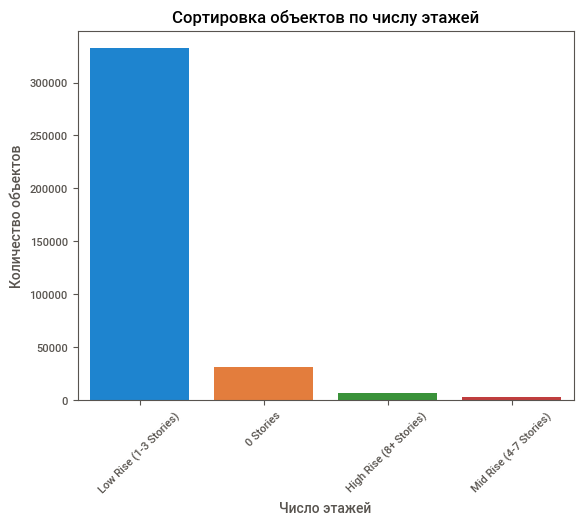

In [23]:
# Теперь заполним значения для всех остальных типов недвижимости
for p in proper_type:
    if p == 'Condo': # если тип недвижимости - квартира
        continue     # пропускаем его, т.к. он уже обработан
    # Отфильтруем датафрейм по типу недвижимости
    ind = df[df['propertyType'] == p].index
    # Присвоим категорию этажности всем объектам данного типа
    df.loc[ind, 'stories'] = proper_type[p]

# Убедимся, что пустых значений в признаке не осталось
print('Пустых значений в признаке stories: ', df['stories'].isna().sum())

# Посмотрим на распределение объектов в зависимости от числа этажей
barplot = sns.barplot(
    data = df['stories'].value_counts().to_frame().reset_index(),
    y = 'stories',
    x = 'index'
);
barplot.set_title('Сортировка объектов по числу этажей');
barplot.set_xlabel('Число этажей');
barplot.set_ylabel('Количество объектов');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

del ind # очистим память

### 3.6. Обработка признака "количество ванных комнат" "baths"  

Выделим из ячейки типа object количество ванных комнат и сохраним его в формате float, тк. в df часто встречаются дробные значения ванных комнат, например: 3.5, 1.75.
Также есть аномальные значения, которые превышают тысячи до знака запятой. Предположим, что это опечатка, и отбросим нули. 
Напишем функцию преобразования и применим ее к столбцу "baths".  

In [24]:
# Напишем функцию для выделения числа ванных из строки
def bath_num(b: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество ванных комнат в формате float.
    Возвращает это количество или NaN, если оно не было в строке.

    Функция возвращает float без округления, т.к. дробные значения
    могут означать не полные ванные комнаты, а, например, ванную
    с душевой кабинкой, или туалет.

    Например (исх. строка -> результат работы функции):
    - '4 ba' -> 4.0
    - '3.5 Baths' -> 3.5
    - '1,500' -> 1500
    - NaN -> NaN
    - '~' -> NaN

    Args:
        b (str): строка с количеством ванных комнат

    Returns:
        float: количество ванных комнат или NaN
    """

    if b is np.NaN:
        result = np.NaN # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'\d+\.*,*\d*', b) # выделяем число ванных
        if len(result) > 0:
            result = result[0] # если оно содержалось в строке, оно - на 1-м месте списка
            result = float(result.replace(',', '')) # убираем запятую-разделитель тысяч и приводим к float
            if result >= 1000: # устраняем опечатку
                result = result / 1000
        else:
            result = np.NaN # если в строке не было числа комнтат, сохраним NaN

    return result

# Применяем написанную функцию и преобразуем признак baths
df['baths'] = df['baths'].apply(lambda b: bath_num(b))

Построим диаграммы, чтобы увидеть возможные выбросы после удаления 00 в показателях признака baths.  

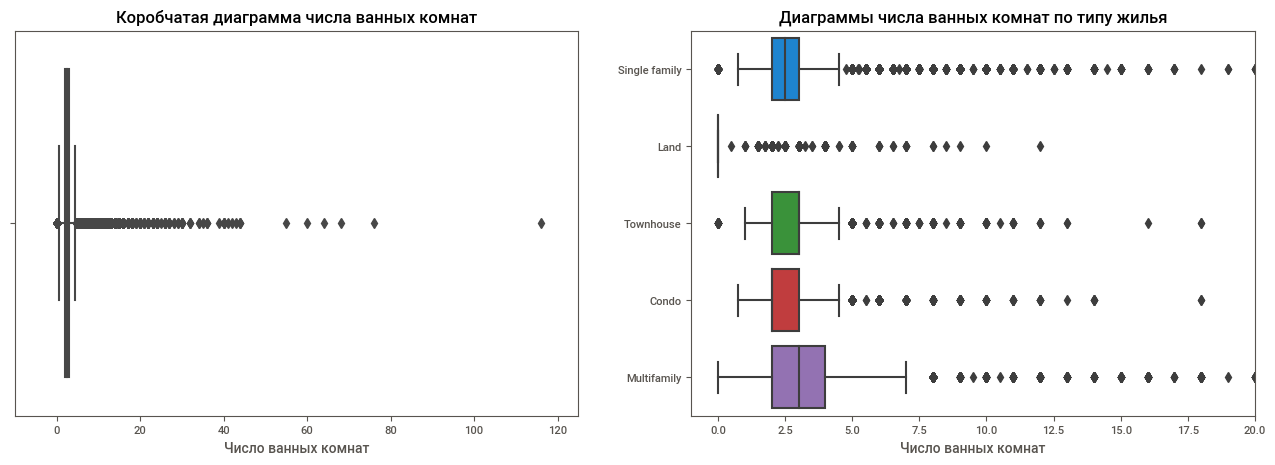

In [25]:
# Построим две коробчатые диаграммы признака baths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Общую диаграмму признака
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    ax = axes[0]
);
boxplot.set(xlim=(-10,125)); # ограничим диапазон, т.к. есть выбросы = 750
boxplot.set_title('Коробчатая диаграмма числа ванных комнат');
boxplot.set_xlabel('Число ванных комнат');

# И диаграмму с разбивкой на типы жилья
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    y = 'propertyType',
    ax = axes[1]
);
boxplot.set(xlim=(-1,20)); # ограничим диапазон, т.к. есть выбросы = 750
boxplot.set_title('Диаграммы числа ванных комнат по типу жилья');
boxplot.set_xlabel('Число ванных комнат');
boxplot.set_ylabel('');

Предположим, что в доме для одной семьи количество ванных не превышает 1-3 единиц. В многосемейных домах, возможно, это количество соотвествует количеству семей. Из-за этого левая диаграмма для всего признака малоинформативна, Справа диаграмма разбита по типу жилья - здесь медиана для каждого типа находится в диапазоне 2-3 (за исключением земельного участка Land, где нет построек и соответственно нет ванных комнат).  

Определим выбросы методом Тьюки, проверив распределены ли наши данные нормально. Для этого воспользуемся тестом Шапиро-Уилка.  


In [26]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака ванных комнат
_, p = shapiro(df['baths'])
print('Результаты теста Шапиро-Уилка:')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

Результаты теста Шапиро-Уилка:
p = 1.000
Данные распределены нормально


По результатам теста мы можем воспользоваться методом Тьюки и выявить выбросы в количестве ванных комнат 

In [27]:
# Функция определения выбросов по методу Тьюки
def outliers_iqr(data: pd.DataFrame,
                 feature: str) -> tuple:
    """Функция определяет выбросы по методу Тьюки. Для этого она
    получает на вход df с выбросами и название признака,
    а возвращает кортеж из двух df: выбросы и очищенные
    данные.

    Args:
        data (pd.DataFrame): датафрейм с выбросами
        feature (str): название признака для очистки

    Returns:
        tuple: кортеж из df (выбросы и очищенные данные)
    """
    # Вычисляем квартили и межквартильное расстояние
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    # Определяем границы диапазона
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)

    # Определяем выбросы и очищенные записи
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]

    # Возвращем результат в виде кортежа датафреймов
    return outliers, cleaned

In [28]:
# Применим написанную функцию и выведем результаты ее работы на экран
outliers, cleaned = outliers_iqr(df, 'baths')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Итоговое число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном df: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству ванных комнат среди выбросов:',
    outliers['baths'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 23498
Итоговое число записей: 242406
Процент выбросов в исходном df: 6.28%


'ТОП-5 по количеству ванных комнат среди выбросов:'

5.0    9435
6.0    4290
0.0    3911
7.0    2072
8.0    1158
Name: baths, dtype: int64

C помощью метода Тьюки как выбросы обозначились такие объекты недвижимости, где количество ванных комнат >= 5. Нулевые значения также оказались выбросами. Так как есть пустые участки, и соответственно на них нет ванных комнат то этим может объясняться количество нулевых значений. Требуется также определить как выброс все те объекты, где число ванных комнат больше 7 и если он небольшой, то удалим его.  

In [29]:
# Проверим количество объектов, у которых ванных больше, чем 7
baths_7_plus = df[df['baths'] > 7].index
print(f'Более 7 ванных комнат насчитывается в {len(baths_7_plus)} объектах')
print('Это составляет  {:2.2%} всего df'.format(len(baths_7_plus)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(baths_7_plus, axis=0, inplace=True)
del baths_7_plus

Более 7 ванных комнат насчитывается в 3075 объектах
Это составляет  0.82% всего df


Требуется начать заполнение пропусков - используем медиану для каждого из типа недвижимости для большей точности расчетов

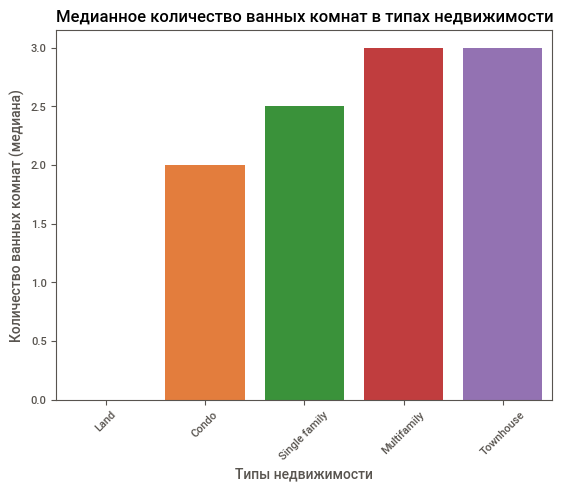

In [30]:
# Вычислим медианное значение ванных комнат для разных типов недвижимости
proper_bath_med = df.groupby('propertyType')['baths'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_bath_med.to_frame().reset_index(),
    y = 'baths',
    x = 'propertyType'
);
barplot.set_title('Медианное количество ванных комнат в типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество ванных комнат (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

К пропускам отнесем нулевое количество ванных комнат в домах и сосчитаем их  

In [31]:
display('Нулевое количество ванных комнат в различных типах жилья:',
        df[df['baths'] == 0].groupby('propertyType')['baths'].count())

'Нулевое количество ванных комнат в различных типах жилья:'

propertyType
Land             3707
Multifamily        32
Single family     148
Townhouse          24
Name: baths, dtype: int64

Т.к Land -  пустой участок без жилья, то данное нулевое количство - вариант нормы
Поэтому заполним одновременно пропуски, а также заменим нулевые значения на медианы по типу недвижимости.  

In [32]:
# Запускаем цикл по всем типам недвижимости
for p in proper_bath_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['baths'].isna() == True # маска по пропускам в baths
    mask3 = df['baths'] == 0 # маска по нулевым значениям
    ind = df[mask1 & (mask2 | mask3)]['baths'].index # сохраняем индекс
    df.loc[ind, 'baths'] = proper_bath_med[p] # приcваиваем медиану

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке baths:', df['baths'].isna().sum())
# Проверяем, что нулевое количество ванных осталось только в Land
display('Нулевое количество ванных комнат в различных типах жилья:',
        df[df['baths'] == 0].groupby('propertyType')['baths'].count())

del mask1, mask2, mask3, ind, proper_bath_med # очистим память

Осталось пропусков в признаке baths: 0


'Нулевое количество ванных комнат в различных типах жилья:'

propertyType
Land    30777
Name: baths, dtype: int64

Поправить значения, которые выбиваются из общей концепции обозначения ванных: 1.1, 3.2. Т.к. таких случаев мало - отбросим все после точки.  

In [33]:
ind = df[df['baths'] % 0.25 != 0]['baths'].index
df.loc[ind, 'baths'] = df.loc[ind, 'baths'].round()
print(f'Произведено {len(ind)} замен')

Произведено 80 замен


### 3.7. Обработка признака "город" "city"

Данный признак нам пригодится в разделе EDA при проектировании других признаков, поэтому обработаем его:  
- заменим пустые строки, а также значения "other" на названия городов (для этого воспользуемся признаком почтового кода "zipcode"),
- разделим написание "city" с именем города (например, "commercecity"),   
- заменим распространенные сокращения на полные назания ("pt" -> "port"),  
- заменим редко встречающиеся в датафрейме названия городов на более распространенные ("e. new york" -> "brooklyn").  

Сначала приведем все названия к нижнему регистру.  



In [34]:
# Приводим к нижему регистру
df['city'] = df['city'].str.lower()

#### Обработка пустых названий и other  

In [35]:
# Создадим датафрейм для подбора подходящего названия города по индексу
zip_city_df = df.groupby(['zipcode', 'city'])['city'].count()

# Отберем все города, где вместо названия содержится слово other
ind = []
ind.extend(df[df['city'].str.contains('other') == True].index)
ind.extend(df[df['city'] == ' '].index)
print('Произведено коррекций в записях, где вместо названий городов либо other, либо два пробела:',
      len(ind))

# Заменим на наиболее подходящее название города
df.loc[ind, 'city']\
= df.loc[ind, ['zipcode']]\
.applymap(lambda x: zip_city_df[x].sort_values(ascending=False).index[0]).squeeze()

# Для записей, для которых не удалось подобрать название города по индексу,
# оставим other, чтобы не терять данные для обучения
ind = df[df['city'].str.contains('other') == True].index
print(f'Не получилось заменить other в {len(ind)} записях.')
df.loc[ind, 'city'] = 'other'

Произведено коррекций в записях, где вместо названий городов либо other, либо два пробела: 78
Не получилось заменить other в 3 записях.


#### Обработка опечаток - слитного написания city

In [36]:
# Отберем все города, где слово city написано слитно
ind = df[df['city'].str.contains(r'\wcity') == True].index
print('Исправлено записей, где city написано слитно:', len(ind))

# Заменим на наиболее подходящее название города
p = re.compile('(\w+)city') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: p.findall(x)[0] + ' city').squeeze()


Исправлено записей, где city написано слитно: 67


#### Обработка сокращений

- [X] st -> saint  
- [X] pt -> port  
- [X] ft -> fort  
- [X] mt -> mount  
- [X] twp -> township

In [37]:
# Отберем все города, где вначале написано st или st.
ind = df[df['city'].str.match('(st\.*)\s+') == True].index
print('Исправлено записей с сокращениями st/st.:', len(ind))

# Заменим на наиболее подходящее название города
p = re.compile('(st\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'saint ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями st/st.: 1665


In [38]:
# Отберем все города, где есть сокращение pt/pt.
ind = df[df['city'].str.match('(pt\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями pt/pt.:', len(ind))

# Заменим на развернутое port
p = re.compile('(pt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'port ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями pt/pt.: 242


In [39]:
# Отберем все города, где есть сокращение ft/ft.
ind = df[df['city'].str.match('(ft\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями ft/ft.:', len(ind))

# Заменим на развернутое fort
p = re.compile('(ft\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'fort ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями ft/ft.: 32


In [40]:
# Отберем все города, где есть сокращение mt/mt.
ind = df[df['city'].str.match('(mt\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями mt/mt.:', len(ind))

# Заменим на развернутое mount
p = re.compile('(mt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'mount ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями mt/mt.: 4


In [41]:
# Отберем все города, где есть сокращение twp/twp.
ind = df[df['city'].str.contains('\s+(twp\.?)', case=False) == True].index
print('Исправлено записей с сокращениями twp/twp.:', len(ind))

# Заменим на развернутое township
p = re.compile('\s+(twp\.?)') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: x[:p.search(x).start()] + ' township').squeeze()

Исправлено записей с сокращениями twp/twp.: 50


#### Обработка прочих редко встречающихся названий  

In [42]:
# Заменим сокращенные/редкие названия городов на полные
df.loc[df[df['city'] == 'new york city'].index, 'city'] = 'new york'
df.loc[df[df['city'] == 'e. new york'].index, 'city'] = 'brooklyn'
df.loc[df[df['city'] == 'point charlotte'].index, 'city'] = 'port charlotte'
df.loc[df[df['city'] == 'p c beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'west panama city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'piney pt village'].index, 'city'] = 'piney point village'
df.loc[df[df['city'] == 'city center'].index, 'city'] = 'las vegas'
df.loc[df[df['city'] == 'pete beach'].index, 'city'] = 'saint pete beach'
df.loc[df[df['city'] == 'atlaanta'].index, 'city'] = 'atlanta'
df.loc[df[df['city'] == 'n miami beach'].index, 'city'] = 'miami beach'

# Выведем результат работы
print('Осталось уникальных значений городов:', df['city'].nunique())

# Удаляем ненужные более признак индекса и очищаем память
df.drop('zipcode', axis=1, inplace=True)
del zip_city_df, ind, p

Осталось уникальных значений городов: 1857


Количество уникальных названий уменьшено на 150 ед. Следовательно, можно удалить признак "zipcode" за ненадобностью.  

### 3.8. Обработка признака "площадь в футах" "sqft"  

Необходимо преобразование ризнака в числовой.  


In [43]:
# Функция для выделения площади жилья
def sqft_num(s: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество квадратных футов. Возвращает это количество или NaN,
    если оно не было в строке.

    Args:
        s (str): строка с количеством квадратных футов из признака sqft

    Returns:
        float: количество квадратных футов
    """

    if (s is np.NaN) or (s is None):
        result = np.NaN  # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'(\d+)', s) # выделяем квадратные футы
        if len(result) > 0:
            result = result[0] # если они найдены, сохраняем их
        else:
            result = np.NaN # если не найдены, вернем NaN

    # Возвращаем результат в виде float
    return result

In [44]:
# Удаление запятых, отделяющих тысячные разряды
df['sqft'] = df['sqft'].str.replace(',', '')

# Выделяем квадратные футы
df['sqft'] = df['sqft'].apply(sqft_num).astype(float)

# Заменяем нулевые значения на пропуски
ind = df[df['sqft'] == 0].index
df.loc[ind, 'sqft'] = np.NaN
del ind

### 3.9. Обработка признака "количество спален" "beds"  

Количество пропущенных значний 90825 - менее 30%. Признак содержит количество спальных комнат в виде числа или как  "`n` Beds/bd", где `n` - число спален.   
Необхожимо избавиться о выбросов на этом этапе 

In [45]:
# Функция для выделения числа спален в признаке
def beds_num(s: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество спальных комнат. Возвращает это количество или NaN,
    если оно не было найдено в строке.

    Например (исх. строка -> результат работы функции):
    - '3 Beds' -> 3
    - '10 beds' -> 10
    - '3 bd' -> 3
    - '11 bd' -> 11
    - '15.0 bd' -> 15
    - '-- bd' -> nan
    - '8' -> 8
    - '8.0' -> 8
    - '12' -> 12
    - '12.0' -> 12
    - '10 bath' -> nan
    - 'Bed 14' -> nan

    Args:
        s (str): строка с количеством спален

    Returns:
        float: количество спален
    """

    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    elif s.isdigit():
        result = s # если в строке только число спален без точки, оставляем строку
    else:
        result = re.findall(r'(\d+)\s+[Bb]ed', s) # выделяем число спален из формата 10 Beds
        if len(result) > 0:
            result = result[0]
        else:
            result = re.findall(r'(\d+)\.*\d*\s+bd', s) # выделяем число спален из формата 3.0 bd
            if len(result) > 0:
                result = result[0]
            else:
                result = re.findall(r'(\d+)\.', s) # выделяем число спален из формата 10.0
                if len(result) > 0:
                    result = result[0]
                else:
                    result = np.NaN # если спален нет, а только текст, то - np.NaN

    # Возвращаем число спален в формате float
    return float(result)

# Применяем написанную функцию для выделения числа спален
df['beds'] = df['beds'].apply(beds_num)

# Проверяем долю пустых значений
print('Доля пустых значений в признаке beds: {:2.2%}'.format(df['beds'].isna().sum()/df.shape[0]))

Доля пустых значений в признаке beds: 29.43%


Для проверки распределения данных используем метод Тьюки.

In [46]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака спальных комнат
_, p = shapiro(df['beds'])
print('Результаты теста Шапиро-Уилка:')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

Результаты теста Шапиро-Уилка:
p = 1.000
Данные распределены нормально


In [47]:
# Воспользуемся ранее написанной функцией для определения выбросов
outliers, cleaned = outliers_iqr(df, 'beds')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Итоговое число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном df: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству спален среди выбросов:',
    outliers['beds'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 17702
Итоговое число записей: 244158
Процент выбросов в исходном df: 4.77%


'ТОП-5 по количеству спален среди выбросов:'

1.0    6395
6.0    5793
0.0    2275
7.0    1368
8.0     935
Name: beds, dtype: int64

Метод Тьюки отнес к выбросам 0 спален и 1 спальню, а также больше 5. Учитывая, что число спален и ванных комнат взаимозависимы в некотором роде, следует проверить гипотезу о том, что ванных комнат не больше, чем спален в доме. Для этого вычислим отношение и медиану.   

In [48]:
print('Соотношение числа спален к числу ванных:', (df.beds / df.baths).median())

Соотношение числа спален к числу ванных: 1.25


Гипотеза верна: имея обработанный признак "baths" мы можем заменять пропуски и нули на медиану и сверяться с вычисленным значением "beds".  

Нижнюю границу выбросов опустим до 0: спальни отсутствуют на пустых участках земли (и в постройках, не являющихся домами, но отнесенными к типу "Sigle family" ранее), и 1 спальня вполне может быть в недорогом односемейном доме.  

Верхняя граница выбросов: Посколько для ванных мы ограничили данные чилом 7, следовательно спален в таком случае может быть: `7 * 1.25 = 8.75`. Округлим до 9. Тогда будем считать выбросами все записи, в которых число спален превышает 9.  

Проверим их число, удалим и посчитаем медиану для каждого типа недвижимости.  

In [49]:
# Проверим количество объектов, у которых спален больше 9
beds_9_plus = df[df['beds'] > 9].index
print(f'Более 9 спален насчитывается в {len(beds_9_plus)} объектах')
print('Это составляет {:2.2%} всего df'.format(len(beds_9_plus)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(beds_9_plus, axis=0, inplace=True)
del beds_9_plus

Более 9 спален насчитывается в 564 объектах
Это составляет 0.15% всего df


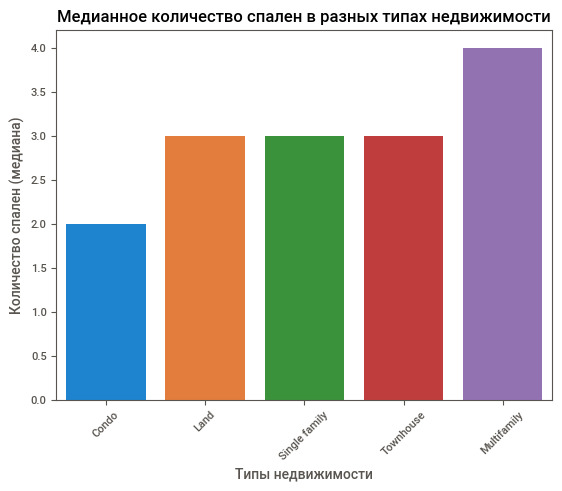

In [50]:
# Вычислим медианное значение спален для разных типов недвижимости
proper_bed_med = df.groupby('propertyType')['beds'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_bed_med.to_frame().reset_index(),
    y = 'beds',
    x = 'propertyType'
);
barplot.set_title('Медианное количество спален в разных типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество спален (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

В df у пустых участков типа "Land"  - были отмечены спальни. Возможно это связано с общим представлением о размерах участка, на котормо может быть возведен дом той или иной размерности. Необходимо заполнить пропуски в этих данных и заменить нули, используя соотношение спален и ванных комнат.

In [51]:

# Запускаем цикл по всем типам недвижимости
for p in proper_bed_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['beds'].isna() == True # маска по пропускам в beds
    mask3 = df['beds'] == 0 # маска по нулям в beds
    ind = df[mask1 & (mask2 | mask3)]['beds'].index # сохраняем индекс
    coef = (df[mask1].beds / df[mask1].baths).median() # вычисляем коэффициент
    # Присваиваем или медиану, или число ванных*коэф. - что больше
    # (причем важно сравнивать именно в таком порядке, чтобы не получить nan)
    df.loc[ind, 'beds'] = df.loc[ind, 'beds']\
                          .apply(lambda x: max(proper_bed_med[p], x*coef))

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке beds:', df['beds'].isna().sum())
# Проверяем, что нулевое количество спален не осталось ни в одном типе жилья
display('Нулевое количество спален в различных типах жилья:',
        df[df['beds'] == 0].groupby('propertyType')['beds'].count())

del mask1, mask2, mask3, ind, coef, proper_bed_med # очистим память

Осталось пропусков в признаке beds: 0


'Нулевое количество спален в различных типах жилья:'

Series([], Name: beds, dtype: int64)

### 3.10. Обработка признака "штат" "state"  

На этапе EDA, в признаке обнаружились несуществующие аббревиатуры штатов. Обработаем этот признак , собрав их в таблицу с количеством записей и способом устранения ошибки.

| Ошибка | Записей | Устранение |  
|---|---:|---|  
| Fl | 1 | Заменить на FL |  
| DC | 4513 | Заменить на WA |  
| BA | 1 | Удалить |  
| OS | 1 | Удалить |  
| OT | 1 | Удалить |  

In [52]:
# Заменим неверные аббревиатуры шатов
df.loc[df[df['state'] == 'Fl'].index, 'state'] = 'FL'
df.loc[df[df['state'] == 'DC'].index, 'state'] = 'WA'

# По остальным сохраним индекс и удалим записи по индексам
ind = []
ind.extend(df[df['state'] == 'BA'].index)
ind.extend(df[df['state'] == 'OS'].index)
ind.extend(df[df['state'] == 'OT'].index)
df.drop(ind, axis=0, inplace=True)

del ind # очистим память

### 3.11. Обработка признака "цена объекта недвижимости" "target"  

Целевой признак стоимости объекта содержит символ $ (Доллар США). Очистим даннные от символа, разделителя (запятой) и знака плюс в конце и приведем к типу `int`.  

Далее проверим на наличие выбросов. При этом снова сгруппируем данные по типу жилья.  

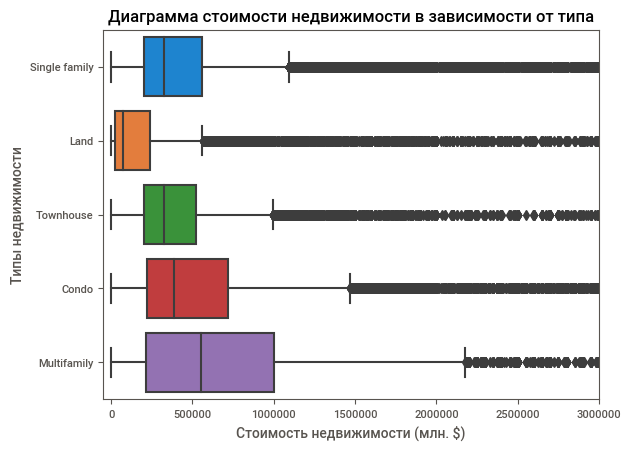

In [53]:
# Очищаем признак target
df['target'] = df['target'].str.replace('$', '', regex=False)
df['target'] = df['target'].str.replace(',', '', regex=False)
df['target'] = df['target'].str.replace('+', '', regex=False).astype(int)

# Построим диаграмму целевого признака с разбивкой на типы жилья
boxplot = sns.boxplot(
    data = df,
    x = 'target',
    y = 'propertyType'
);
boxplot.set(xlim=(-50000,3000000)); # ограничим диапазон из-за выбросов
boxplot.set_title('Диаграмма стоимости недвижимости в зависимости от типа');
boxplot.set_xlabel('Стоимость недвижимости (млн. $)');
boxplot.set_ylabel('Типы недвижимости');

Как можно судить по диаграмме, распределение стоимости недвижимости в любой из групп далеко от нормального (тест Шапиро-Уилка это подтвержает), поэтому воспользоваться методом Тьюки мы не можем.  

Попробуем пролагорифмировать признак.  

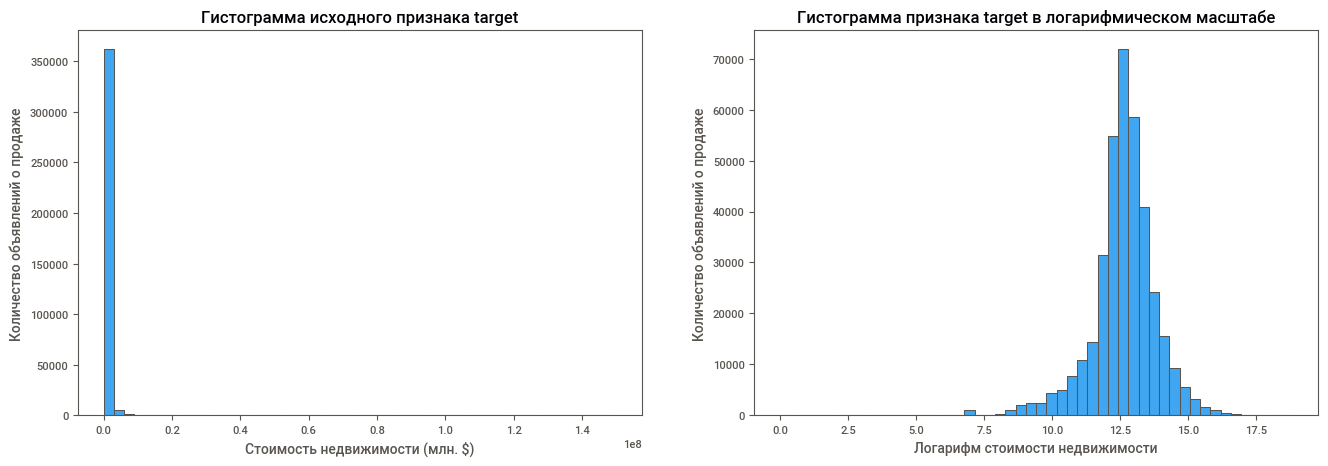

In [54]:
# Построим две гистограммы признака target: без логарифмирования и с таковым
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Гистограмма исходного признака
histplot = sns.histplot(
    data = df['target'],
    bins = 50,
    ax = axes[0]
);
histplot.set_title('Гистограмма исходного признака target');
histplot.set_xlabel('Стоимость недвижимости (млн. $)');
histplot.set_ylabel('Количество объявлений о продаже');

# Гистограмма признака в логарифмическом масштабе
log_target = np.log(df['target']) # min(target) > 0, поэтому смело берем log
histplot = sns.histplot(
    data = log_target,
    bins=50,
    ax=axes[1]
);
histplot.set_title('Гистограмма признака target в логарифмическом масштабе');
histplot.set_xlabel('Логарифм стоимости недвижимости');
histplot.set_ylabel('Количество объявлений о продаже');

Итак, благодаря логарифмированию нам удалось привести распределение признака практически к нормальному.  

Для выявления выбросов воспользуемся методом z-отклонений (трех сигм).
Напишем функцию для определения выбросов. Затем построим гистрограммы, на которых отобразим границы выбросов для каждого их типа недвижмости.  

In [55]:
# Функция определения выбросов по методу z-отклонений (трех сигм)
def outliers_z_score(df: pd.DataFrame,
                     feature: str,
                     log_scale: bool = True,
                     left: int = 3,
                     right: int = 3) -> tuple:
    """Функция определяет выбросы среди наблюдений по методу
    z-отклонения, или трех сигм (количество сигм регулируется
    в вызывающем операторе).

    Args:
        df (pd.DataFrame): исходный df
        feature (str): признак, в котором определяем выбросы
        log_scale (bool): переход к лог. масштабу, по умолчанию = True
        left (int): кол-во сигм для нижней границы, по умолчанию = 3
        right (int): кол-во сигм для верхней границы, по умолчанию = 3

    Returns:
        tuple (pd.DataFrame): df с выбросами и очищенный df
    """

    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feature].min() > 0: # если значения признака больше 0
            x = np.log(df[feature])
        else:
            x = np.log(df[feature]+1) # иначе добавляем единицу
    else:
        x = df[feature]

    # Вычисляем мат.ожидание и стандарт. отклонение
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    # Определяем выбросы и очищенные данные
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]

    # Возвращаем кортеж из pd.DataFrame
    return outliers, cleaned

In [56]:
# Создадим списки типов недвижимости ...
property_list = list(df['propertyType'].unique())
# и границ метода z-отклонений для них
boundaries = [(2,2), (2,2), (2,2), (2,2), (2,2)] # первоначальные границы были 3+
# Объединим их в словарь
prop_bound = dict(zip(property_list, boundaries))
# Подготовим список названий цветов для гистограмм
hist_colors = ['blue', 'orange', 'green', 'red', 'purple']

# Добавим признак выброса в датафрейм и установим нули
df['outliers'] = 0

# В цикле вычислим выбросы для каждого типа недвижимости
for i, p_type in enumerate(prop_bound):
    # Определяем выборосы с помощью написанной функции
    outliers, cleaned = outliers_z_score(df = df[df['propertyType'] == p_type],
                                         feature = 'target',
                                         log_scale = True,
                                         left = prop_bound[p_type][0],
                                         right = prop_bound[p_type][1])

    print(f'Число выбросов по методу z-отклонений для {p_type}: {outliers.shape[0]}')
    print(f'Итоговое число записей для {p_type}: {cleaned.shape[0]}\n')
    # Установим флаг выброса в признаке
    df.loc[outliers.index, 'outliers'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {df.outliers.sum()} выбросов.')

Число выбросов по методу z-отклонений для Single family: 14394
Итоговое число записей для Single family: 238289

Число выбросов по методу z-отклонений для Land: 985
Итоговое число записей для Land: 30333

Число выбросов по методу z-отклонений для Townhouse: 1278
Итоговое число записей для Townhouse: 24945

Число выбросов по методу z-отклонений для Condo: 2343
Итоговое число записей для Condo: 46606

Число выбросов по методу z-отклонений для Multifamily: 523
Итоговое число записей для Multifamily: 10782

Всего по методу z-отклонений выявлено 19523 выбросов.


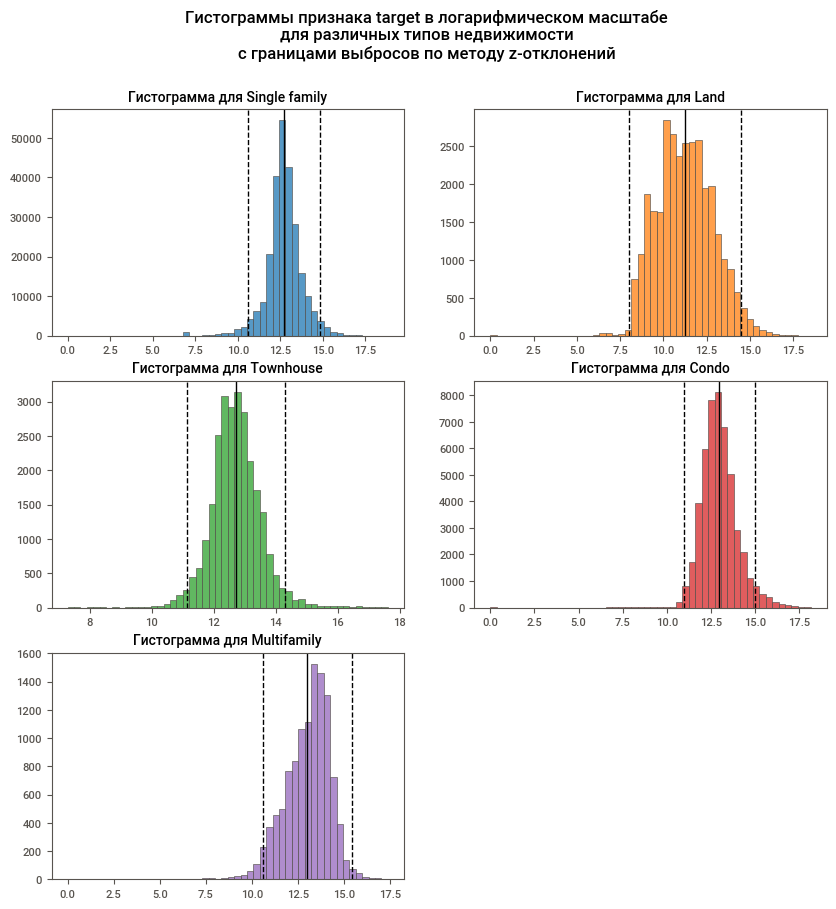

In [57]:
# Следом построим гистограммы для каждого типа с границами выбросов
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Гистограммы признака target в логарифмическом масштабе\n'+\
             'для различных типов недвижимости\n'+\
             'с границами выбросов по методу z-отклонений', fontsize=12);

# Снова воспользуемся циклом
for i, p_type in enumerate(prop_bound):
    # Переводим признак в логарифмическую шкалу
    if df[df['propertyType'] == p_type]['target'].min() > 0:
        log_target = np.log(df[df['propertyType'] == p_type]['target'])
    else:
        log_target = np.log(df[df['propertyType'] == p_type]['target']+1)

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + prop_bound[p_type][1] * log_target.std()
    lower_bound = log_target.mean() - prop_bound[p_type][0] * log_target.std()

    # Строим гистрограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data = log_target,
        bins = 50,
        ax = axes[divmod(i, 2)],
        color = 'tab:' + hist_colors[i]
    );
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    histplot.set_title(f'Гистограмма для {p_type}', fontsize=10);
    histplot.set_xlabel('');
    histplot.set_ylabel('');
fig.delaxes(axes[2, 1]); # удалим неиспользуемое поле

Отмечено что наименее нормальные распределения среди типов недвижимости Land и Multifamily.  

Такое распределение для земельных участков связано, возможно, с размерами.  
В группе мультисемейных домов наблюдается левосторонняя ассиметрия из-за большого числа домов по цене ниже моды. 
Наиболее популярный ценовой сегмент представлен на гистограмме тремя столбцами, начиная с моды, впосле чего число объектов резко падает.  

На всех гистограммах выраженные длинные хвосты и аномальные всплески вдали от центра. Все эти записи вносили чувствительную ошибку в прогноз, поэтому границы отклонений сужены до 2.

Примерно 19,5 тыс. выбросов отобрано и отмечено маркером в признаке "outliers". Не исключено, что их нужно будет удалить впоследствии.  

Определим распределение стоимости объектов по штатам.  


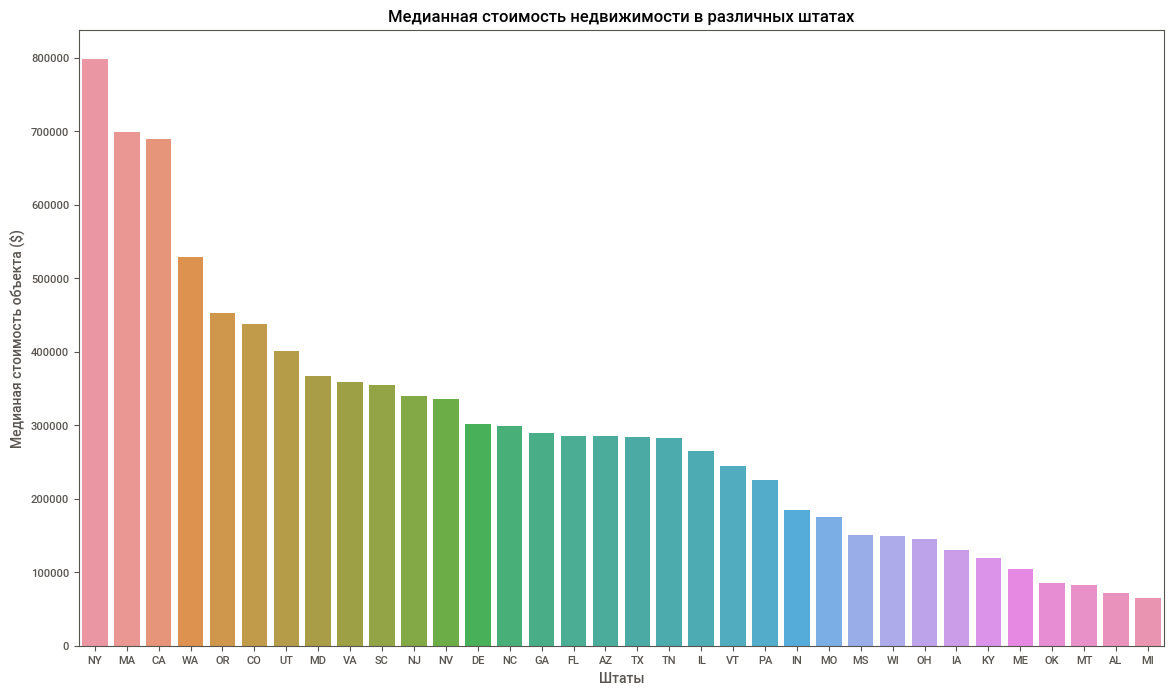

In [58]:
# Сгруппируем объекты по штатам и посчитаем медиану
state_target_gr = df.groupby('state')['target'].median()
state_target_gr = state_target_gr.to_frame(name='median').reset_index()
state_target_gr = state_target_gr.sort_values(by='median', ascending=False)

# Построим график зависимости стоимости от штата
fig = plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    state_target_gr,
    x = 'state',
    y = 'median'
);
barplot.set_title('Медианная стоимость недвижимости в различных штатах');
barplot.set_xlabel('Штаты');
barplot.set_ylabel('Медианая стоимость объекта ($)');

Ожидаемо, наиболее высокая стоимость недвижимости в штате Нью-Йорк. Далее Массачуссетс и Калифорния. Флорида (где очень много яхт), находится в середине графика, как ни странно.  

Самые дешевые объекты: Мичиган, Алабама и Монтана.  

Распределение по штатам, а не по городам оказалось действенным  

## 4. Базовое решение задачи предсказания (Baseline modeling)  

Итак, предобработка и очистка данных завершена - мы готовы построить baseline-решение. С этой целью мы используем два алгоритма:  
- простую модель обратной регресии, чтобы на ее примере увидеть результат дальнейшей обработки данных в разделе EDA,  
- мощную модель CatBoostRegressor с параметрами по умолчанию, чтобы продемонстрировать довольно высокий результат лишь после предварительной обработки данных.  

Перед обучением моделей отбросим необработанные признаки "street", "homeFacts", "city" и "schools" и закодируем оставшиеся категориальные. Избавимся также от пропущенных значений в признаке "sqft" (которые мы собираемся обработать в следующем разделе). Их доля составляет 11%, так что это не должно повлиять на результаты.  

Для оценки качества моделирования на протяжении всего проекта мы будем использовать три метрики качества:  
- `MAE` - среднюю абсолютную ошибку, чтобы понимать, на сколько тысяч долларов ошиблась модель,
- `MAPE` - среднюю абсолютную ошибку в процентах поскольку стоимость жилья - вещь относительная,    
- `R2` - коэффициент детерминации, чтобы понимать, насколько хорошо модель улавливает закономерности - целевая метрика.   

In [59]:
# Удаляем текстовые признаки
df_baseline = df.drop(['street', 'homeFacts', 'city', 'schools'], axis=1)
# Удаляем пропущенне значения
df_baseline = df_baseline.dropna()

# Удаляем выбросы, найденные при обработке признака "target"
ind = df_baseline[df_baseline['outliers'] == 1].index
df_baseline = df_baseline.drop(ind, axis=0)
del ind

display('Количество уникальных значений в категориальных признаках:',
        df_baseline.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status           5
propertyType     5
state           33
stories          4
dtype: int64

Для признака "state" используем Binary Encoder т.к. число уникальных значений больше 15, а для остальных - OneHot Enoder.

In [60]:
# Создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType', 'stories']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df_baseline[oh_cols])
# Присоединяем к df закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df_baseline[['state']])
# Присоединяем к df закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер df
df_baseline = df_baseline.drop(['status', 'propertyType', 'stories', 'state'], axis=1)
print('Размер получившегося df:', df_baseline.shape)

Размер получившегося df: (305224, 25)


In [61]:
# Uотовим выборки
X = df_baseline.drop('target', axis=1)
y = df_baseline['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверztv размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213656, 24) (91568, 24) (213656,) (91568,)


In [62]:
# Функция для расчета метрик и вывода на экран
def show_metrics(y_train: pd.Series,
                 y_train_pred: pd.Series,
                 y_test: pd.Series,
                 y_test_pred: pd.Series,
                 precision: int = 2,
                 show: bool = True) -> tuple:
    """Функция выводит на экран значения метрик MAE, MAPE и R2
    с заданной точностью, а также возвращает их.

    Args:
        y_train (pd.Series): тренировочный вектор ответов
        y_train_pred (pd.Series): тренировочный предсказанный вектор
        y_test (pd.Series): тестовый вектор ответов
        y_test_pred (pd.Series): тестовый предсказанный вектор
        precision (int): точность округления, по умолчанию = 2
        show (bool): флаг вывода на экран, по умолчанию = True

    Returns:
        tuple (float): кортеж из 6 метрик на случай необходимости
    """

    # Вычислим метрики и выведем их на экран
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
    r2_test = r2_score(y_test, y_test_pred)

    if show: # если флаг вывода на экран установлен
        print('MAE на тренировочоной выборке:', round(mae_train, precision))
        print('MAPE на тренировочной выборке:', round(mape_train, precision))
        print('r2 на тренировочоной выборке:', round(r2_train,2))

        print('\nMAE на тестовой выборке:', round(mae_test, precision))
        print('MAPE на тестовой выборке:', round(mape_test, precision))
        print('r2 на тестовой выборке:', round(r2_test,2))

    # Вернем вычисленные метрики
    return mae_train, mape_train, r2_train, mae_test, mape_test, r2_test

In [63]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# И выведем результаты
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 247260.4
MAPE на тренировочной выборке: 84.0
r2 на тренировочоной выборке: 0.25

MAE на тестовой выборке: 249292.8
MAPE на тестовой выборке: 84.66
r2 на тестовой выборке: 0.25


In [64]:
# Обучим модель CatBoostRegressor
# Подготовим выборки в формате класса Pool
train_pool = Pool(X_train,
                  y_train)
test_pool = Pool(X_test)

# Создаем модель с параметрами по умолчанию
model = CatBoostRegressor(random_state = 42,
                          verbose = False)

# Обучаем модель
model.fit(train_pool)

# Делаем предсказание
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 168579.74
MAPE на тренировочной выборке: 50.31
r2 на тренировочоной выборке: 0.59

MAE на тестовой выборке: 173372.56
MAPE на тестовой выборке: 51.68
r2 на тестовой выборке: 0.57


In [65]:
# Очистим память
del df_baseline, X, y, X_train, X_test, y_train, y_test,\
    train_pool, test_pool, model, y_train_pred, y_test_pred

> Выводы по baseline-решению:
>
> 1. Простая модель линейной регресии показала низкие результаты: ошибка в 250 тыс., или 84% и коэф. детерминации R2 = 0.25 (max = 1). Это означает, что модель не увидела закономерностей в данных.
> 2. Продвинутая модель CatBoostRegressor показала более высокий результат: ошибка в 173 тыс. долларов, или 51% на тестовых данных, и R2 = 0.57. Это означает, что модель отследила закономерности в данных.


## 5. Разведывательный анализ данных 

### 5.1. Обработка признака "сведения о строительстве дома" "homeFacts"  

В этом признаке содержится сериализованный словарь данных об объекте недвижимости:  
- Year built - год постройки,  
- Remodeled year - год обновления,  
- Heating - вид отопления,  
- Cooling - вид охлаждения,  
- Parking - наличие парковки,  
- lotsize - размер участка,  
- Price/sqft - цена за квадратный фут.  

Напишем функцию, которая будет предобрабатывать строку, находящуюся в ячейке, и десериализовывать ее, возвращая 7 перечисленных значений. 

In [66]:
# Функция десериализации строки со словарем значений
def deserialize_home(s: str) -> pd.Series:
    """Функция возвращат значения словаря, который находится
    в сериализованном виде в строке s.

    Args:
        s (str): строка с сериализованным словарем

    Returns:
        pd.Series: список из значений словаря в виде объекта Series
    """

    # Десериализуем строку в словарь и сразу сохраним его единственое значение
    # json.loads() не подошел, т.к. в признаке неодинаковое использование
    # одинарных кавычек, поэтому используем eval()
    result = eval(s)['atAGlanceFacts']

    # В единственном значении словаря хранится список из 7 элементов,
    # каждый из которых представлен двумя словарями: factValue и factLabel
    # С помощью дополнения списка сохраним в список только factValue
    # и вернем их, а там уже присвоим 7-ми признакам
    return pd.Series([r['factValue'] for r in result])

In [67]:
# Воспользуемся написанной функций, чтобы создать новые признаки из homeFacts
df[['yearBuilt', 'remodeledYear', 'heating', 'cooling',
    'parking', 'lotsize', 'price_sqft']] = df['homeFacts'].apply(deserialize_home)

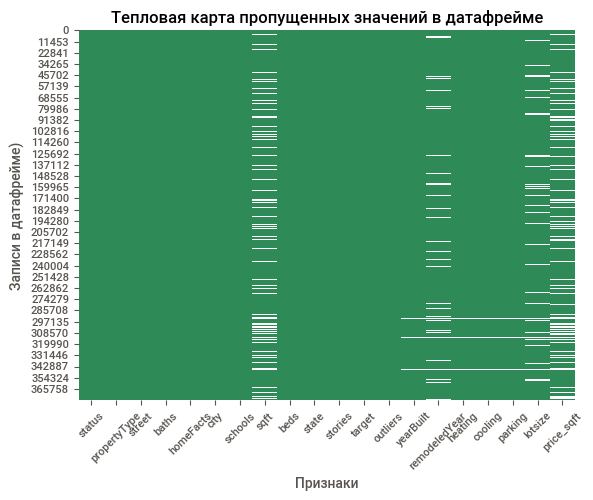

In [68]:
# Построим тепловую карту пропущенных значений в датафрейме
heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['blue', 'white']),
    cbar = False
);
heatmap.set_title('Тепловая карта пропущенных значений в датафрейме');
heatmap.set_xlabel('Признаки');
heatmap.set_ylabel('Записи в датафрейме)');
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

Оставшиеся пропуски также необходимо обработать.

### 5.2. Обработка признаков "yearBuilt" и "remodeledYear"  

Вычислим возраст здания или участка. Для этого возьмем наибольшее из двух значений (год постройки или год обновления) и сравним с текущим годом (2023), сначала объединив эти признаки и убрав пустые значения. 

In [69]:
# Посчитаем пропущенные значения в новых признаках (NaN + пустые ячейки)
yb_na = df['yearBuilt'].isna().sum()
yb_na += df[df['yearBuilt'] == ''].shape[0]
yb_na_share = round(yb_na / df.shape[0] * 100, 2)

yr_na = df['remodeledYear'].isna().sum()
yr_na += df[df['remodeledYear'] == ''].shape[0]
yr_na_share = round(yr_na / df.shape[0] * 100, 2)

print(f'Количество пустых ячеек в yearBuilt - {yb_na}, что составляет {yb_na_share}%.')
print(f'Количество пустых ячеек в remodeledYear - {yr_na}, что составляет {yr_na_share}%.')

Количество пустых ячеек в yearBuilt - 61745, что составляет 16.67%.
Количество пустых ячеек в remodeledYear - 222321, что составляет 60.01%.


In [70]:
# Функция объединения признаков yearBuilt и remodeledYear
def year_compare(b, r):
    """Функция получает на вход значение года из двух ячеек,
    сравнивает их друг с другом и возвращает наибольшее из двух.
    Предусмотрена обработка значений типа None и np.NaN: если
    только одно из переданных значение имеет данный тип, то
    возвращается второе. Если же оба значения не содержат год,
    то возвращается None с целью последующего заполнения.

    Args:
        b (str | NoneType): значение признака yearBuilt
        r (str | NoneType): значение признака remodeledYear

    Returns:
        str | NoneType: наибольший год из двух, либо None
    """

    if (b == np.NaN) or (b == None) or (b == ''): # если в b нет года
        if (r is np.NaN) or (r == None) or (r == ''): # и в r нет года
            result = None # то вернем None
        elif r.isdigit(): # если же в r есть год
            result = r # то вернем r
        else:
            result = None # иначе вернем None (маловероятный сценарий)
    elif b.isdigit(): # если же в b есть год
        if (r == np.NaN) or (r == None) or (r == ''): # а в r нет года
            result = b # то вернем b
        elif r.isdigit(): # если же в r тоже есть год
            if int(b) >= int(r): # сравним, и, если b больше или равен r
                result = b # то вернем b
            else:
                result = r # иначе - r
        else:
            result = None # если r и не None, и не год, то вернем просто b
    else:
        result = None # если ни одно не год и не None, то вернем None (маловероятный сценарий)

    #Возвращаем результат работы функции (в виде строки)
    return result

# Создадим признак, объединяющий два с помощью функции выше
df['lastYear'] = df[['yearBuilt', 'remodeledYear']].apply(lambda x: year_compare(*x), axis=1)

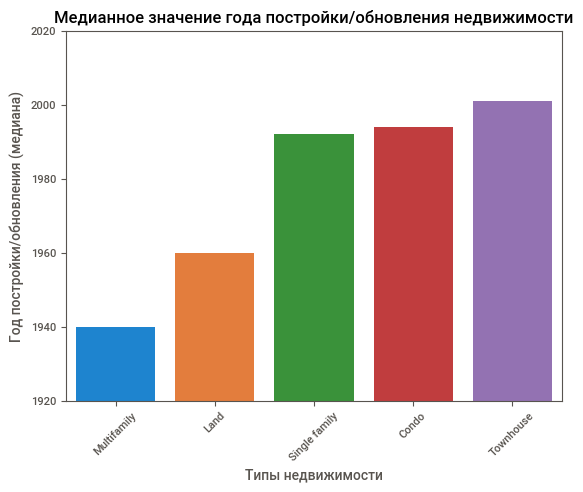

In [71]:
# Вычислим медианное значение года постройки или обновления для разных типов недвижимости
proper_year_med = df.groupby('propertyType')['lastYear'].median().sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_year_med.to_frame().reset_index(),
    y = 'lastYear',
    x = 'propertyType'
);
barplot.set_title('Медианное значение года постройки/обновления недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Год постройки/обновления (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);
barplot.set(ylim=(1920,2020)); # ограничим диапазон по вертикали для наглядности

Судя по диаграмме, наиболее старыми являются многосемейные дома.  
Примерно одинаково развивалость строительство частных домов на 1 семью и квартиры. Далее стало развиваться строительство таунхаусов

Используем эти медианные значения, чтобы заполнить пропуски в признаке, а затем создадим новый - "age", куда сохраним "возраст" жилья или участка.  

In [72]:
import sys
# Запускаем цикл по всем типам недвижимости и заполняем пропуски медианой
for p in proper_year_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['lastYear'].isna() == True # маска по пропускам в lastYear
    ind = df[mask1 & mask2]['lastYear'].index # сохраняем индекс
    df.loc[ind, 'lastYear'] = proper_year_med[p] # приcваиваем медиану

# Приводим к типу int, потому что даты как таковой в признаке нет
df['lastYear'] = sys.maxsize
df['lastYear'] = df['lastYear'].astype(int)


# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке lastYear:', df['lastYear'].isna().sum())

Осталось пропусков в признаке lastYear: 0


Проверим, есть ли выбросы в получившемся признаке года постройки/обновления. Для этого построим коробчатую диаграмму.  

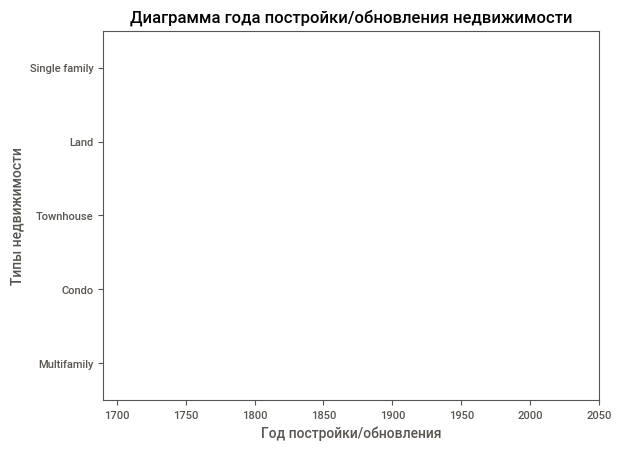

In [73]:
# Построим коробчатую диаграмму признака lastYear
boxplot = sns.boxplot(
    data = df,
    x = 'lastYear',
    y = 'propertyType'
);
boxplot.set(xlim=(1690,2050));
boxplot.set_title('Диаграмма года постройки/обновления недвижимости');
boxplot.set_xlabel('Год постройки/обновления');
boxplot.set_ylabel('Типы недвижимости');

Исходя из диаграммы, выбросами назовем все даты до 1700 года и после 2022 года. Заменим их на медианы.  
А следом сгенерируем новый признак возраста.  

In [74]:
# Запускаем цикл по всем типам недвижимости и заменяем выбросы медианой
for p in proper_year_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = (df['lastYear'] < 1700) | (df['lastYear'] > 2022) # маска по выбросам
    ind = df[mask1 & mask2]['lastYear'].index # сохраняем индекс
    df.loc[ind, 'lastYear'] = proper_year_med[p] # приcваиваем медиану

# Генерируем признак возраста
df['age'] = 2023 - df['lastYear']

# Удаляем ненужные более признаки
df.drop(['yearBuilt', 'remodeledYear', 'lastYear'], axis=1, inplace=True)

del proper_year_med, p, mask1, mask2, ind # и память очистим

### 5.3. Обработка признаков "heating", "cooling", "parking"  

Начнем с проверки пустых значений.  

In [75]:
# Создадим список из трех десериализованных признаков, с которыми будем работать одновременно
hcp_list = ['heating', 'cooling', 'parking']

# Проверим пропуски в них
for f in hcp_list:
  print(f'В признаке {f} найдено {df[f].isna().sum()} пропуска,\
  это {round(df[f].isna().sum()/df.shape[0]*100,2)}% df.')

В признаке heating найдено 3422 пропуска,  это 0.92% df.
В признаке cooling найдено 3422 пропуска,  это 0.92% df.
В признаке parking найдено 3422 пропуска,  это 0.92% df.


Не смотря на малое количество пропусков в этих признаках содержится большое количество повторяющихся значений: пустых строк, нулей, значений 'No Data', значений типа NoneType.  

Поэтому следует трактовать часто встречающиеся значения так:  

- пропуск, отсутствие информации: NaN, None (как тип NoneType без кавычек), 'No Data',  
- отсутствие удобства в доме: ' '(пустая строка в кавычках), '0', 'None' (вручную вписанное значение в кавычках),  
- наличие удобства: все остальные разнообразные значения, не вошедшие в предыдущие две группы.  

Напишем функцию, которая реализует соответствующее преобразование и применим ее к трем признакам.  

In [76]:
# Функция для приведения всех значений признаков к трем категориям
def three_state_feat(s: str) -> str:
    """Функция получает на вход значение из признака и относит
    его к одной из трех категорий: пропуск, отсутствие
    удобства (отопления/кондиционирования/парковки) или
    его наличие. Возвращает одну из трех категорий в виде строки.

    Args:
        s (str | NoneType): значение признака (heating, cooling, parking)

    Returns:
        str: одна из трех категорий
    """

    if (s is None) or (s is np.NaN) or (s == 'No Data'):
        result = 'missing' # категория пропуска
    elif (s == '') or (s == 'None') or (s == '0'):
        result = 'No' # удобство отсутствует
    else:
        result = 'Yes' # иначе удобство есть в наличии

    # Возвращаем результат
    return result

# Применим написанную функцию к трем признакам
for f in hcp_list:
    df[f] = df[f].apply(three_state_feat)

# Проверим отсутствующие значения в признаках после обработки
for f in hcp_list:
  mis = df[df[f] == 'missing'].shape[0]
  print(f'В признаке {f} найдено {mis} отсутствующих значений,\
  это {round(mis/df.shape[0]*100,2)}% df.')

В признаке heating найдено 11743 отсутствующих значений,  это 3.17% df.
В признаке cooling найдено 13735 отсутствующих значений,  это 3.71% df.
В признаке parking найдено 16310 отсутствующих значений,  это 4.4% df.


Заполним увеличившееся количество пропусков.

Начнем группировать по признаку штат - и оценим температурный режим, чтобы обработать признаки отопление\кондициционер. Парковочное место лучше группировать по городам,т.к. наличие порковки маловероятно в многоквартирных домах больших городов, тогда как у односемейного дома в маленьком городе наверняка имеется парковка.   
Чтобы проследить связь с климатом, к нашим таблицам мы добавим взятые в интернете среднегодовые температуры по штатам. И, чтобы упростить работу, будем пользоваться климатическим рейтингом штатов от самого жаркого до самого холодного.  

Температура в градусах Фаренгейта и Цельсия, а также ретинг штата по этим значениям хранятся в тегах \<td>, откуда мы их из заберем.  
Далее из полученного списка сформируем df, сохранив в его столбцы названия штатов, температуру в градусах Цельсия, а также рейтинг. Подобные образом будем действовать при формировании связующего df с названиями и аббревиатурами штатов.   

Итак,  
1) парсим данные о температурах,  
2) объединяем с кросс-таблицами по признакам и иллюстрируем,  
3) выявляем закономерности.  

In [77]:
# Определяем адрес страницы с температурами в штатах и выполняем GET-запрос
url = 'https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с данными о температуре по штатам
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, F, C, рейтинг
temperatures = [r_d.text for r_d in raw_data]

# Фомируем датафрем из названий штатов, средних температур и рейтинга
temp_df = pd.DataFrame(list(zip(temperatures[::4],
                                temperatures[2::4],
                                temperatures[3::4])),
                       columns = ['state_name', 'temp', 'rank'])
# Приведем рейтинг к типу int
temp_df['rank'] = temp_df['rank'].astype(int)


# Теперь проделаем то же самое с целью поиска связки "штат - аббревиатура"
# Определяем адрес страницы с сокращениями штатов и выполняем GET-запрос
url = 'https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с названием и аббревиатурой штата
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, аббревиатура
states_abb = [r_d.text for r_d in raw_data]

# Фомируем датафрем из названий штатов и их аббревиатур
abb_df = pd.DataFrame(list(zip(states_abb[0::2],states_abb[1::2])),
                       columns = ['state_name', 'state'])
# Удаляем лишние символы в начале каждой ячейки
abb_df['state_name'] = abb_df['state_name'].str.strip()
abb_df['state'] = abb_df['state'].str.strip()

# Объединяем два датафрейма
state_temp_df = pd.merge(
    abb_df,
    temp_df,
    on = 'state_name'
).set_index('state')
state_temp_df.head()

# Посмотрим, что у нас получилось
display('Рейтинг штатов по среднегодовым температурам:', state_temp_df.head())

# Очистим память
del url, response, page, raw_data, temperatures, states_abb, temp_df, abb_df

Ошибка парсинга сайта https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php: 403


'Рейтинг штатов по среднегодовым температурам:'

Empty DataFrame
Columns: [state_name, temp, rank]
Index: []

In [78]:
# Функция для создания кросс-таблицы и ее иллюстрации
def cross_diag(feat: str,
               df: pd.DataFrame = df,
               state_temp_df: pd.DataFrame = state_temp_df):
    """Функция строит кросс-таблицу для конкретного признака
    по всем штатам в датафрейме и дополняет ее температурным
    рейтингом штата. Таблица отражает, в каком проценте случаев
    в домах есть удобство (отопление/кондиционирование),
    нет удобстав или информация недоступна.

    Args:
        feat (str): исследуемый признак
        df (pd.DataFrame): исходный датафрейм, по умолчанию = df
        state_temp_df (pd.DataFrame): датафрейм температурного рейтинга

    Returns:
        Функция ничего не возвращает, т.к. выводит диаграммы на экран.
    """

    # Сперва создаем кросс-таблицу с процентами
    # отсутствия и наличия удобства, а также
    # пропущенных значений
    cross = pd.crosstab(
        index = df['state'],
        columns = df[feat],
        normalize = 'index'
    ).sort_values(by='Yes', ascending=False)*100

    # Присоединим датафрейм с рейтингом штатов по температуре
    cross = cross.join(state_temp_df)

    # Создадим словари для подстановки в заголовоки
    word = {'heating': 'отопления',
            'cooling': 'кондиционирования',
            'parking': 'парковок'}
    subtitle = {0: 'Отсутствует в доме',
                1: 'Есть в доме',
                2: 'Данные пропущены'}

    # Выведем на экран диаграммы, иллюстрирующие признак
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
    fig.suptitle(f'Диаграммы наличия {word[feat]} по штатам', fontsize=18)

    # В цикле строим диаграммы по первым трем столбцам кросс-таблицы
    for i, c in enumerate(cross.columns[0:3]):
        stripplot = sns.stripplot(
            data = cross,
            x = c,
            y = cross.index,
            hue = 'rank',
            palette = 'coolwarm_r',
            size = 10,
            linewidth = 1,
            edgecolor = 'w',
            orient = 'h',
            ax = axes[i],
            legend = False
        );
        stripplot.set(xlim=(-3, 103), xlabel='%', ylabel='',
                      title = subtitle[i]);
        if i == 2:
            stripplot.set(xlim=(-1, 12));
        stripplot.xaxis.grid(False);
        stripplot.yaxis.grid(True);
    sns.despine(fig, left=True, bottom=True);

    del cross, word, subtitle, fig, axes # очищаем память

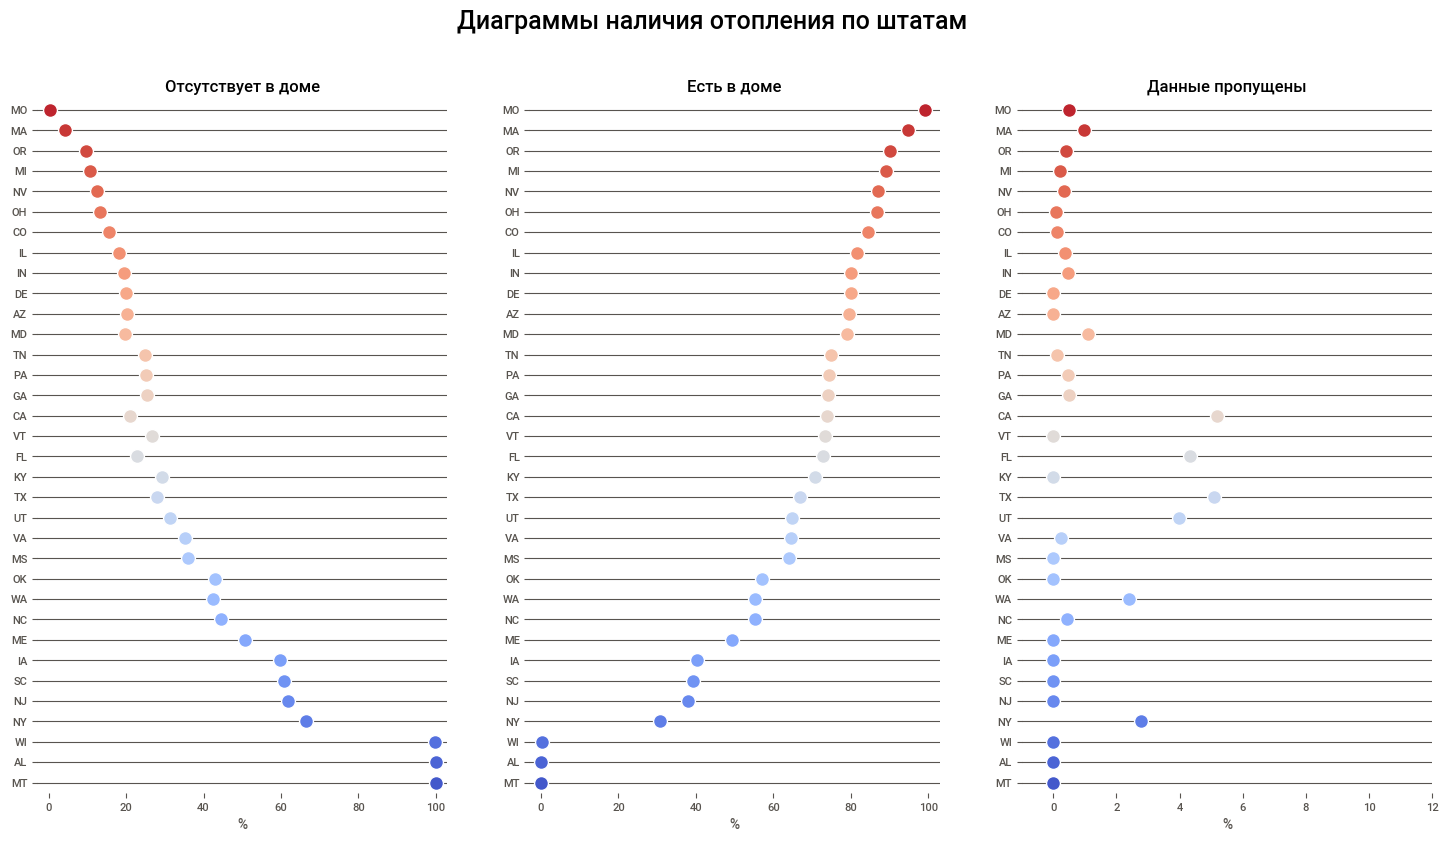

In [79]:
# Построим диаграммы, иллюстрирующие наличие/отсутствие отопления
# в зависимости от штата, с помощью написанной функции
cross_diag('heating')

Цветовая легенда означает рейтинг штата по среднегодовой температуре: от темносинего цвета (самый холодный штат - Maine (ME) в нашем df) до темнокрасного (самый жаркий - Florida (FL)).  

Мы предполагали, что  отопление в домах жарких штатов встречалось гораздо реже, чем в холодных. Некоторым образом, такую закономерность можно выявить. Например, на диаграмме "Отсутствует в доме" в 20% присутствуют голубые и бледно-красные точки, что означает, что в холодных штатах в порядка 20% домов нет отопления.  

По наличию отопления на диаграмме "Есть в доме" в средней части расположились жаркие штаты - от 60% до 80%. Возможно, бывают дни, когда требуется отапливать дом.

Интересно, что на правой диаграмме "Данные пропущенны" наибольшее количество записей (от 4% до 6%) приходится почти только на жаркие штаты. Возможно, мы неверно отнесли значение None (без кавычек, тип NoneType) к пропуску, тогда как в действительности он означал отсутствие отопления в доме?..  

Пока можно сделать вывод, что одно лишь расположение дома в более жарком штате не означает, что отопление в нем отсутствует. Или наоборот - обязательно присутствует в домах из более холодных штатов.

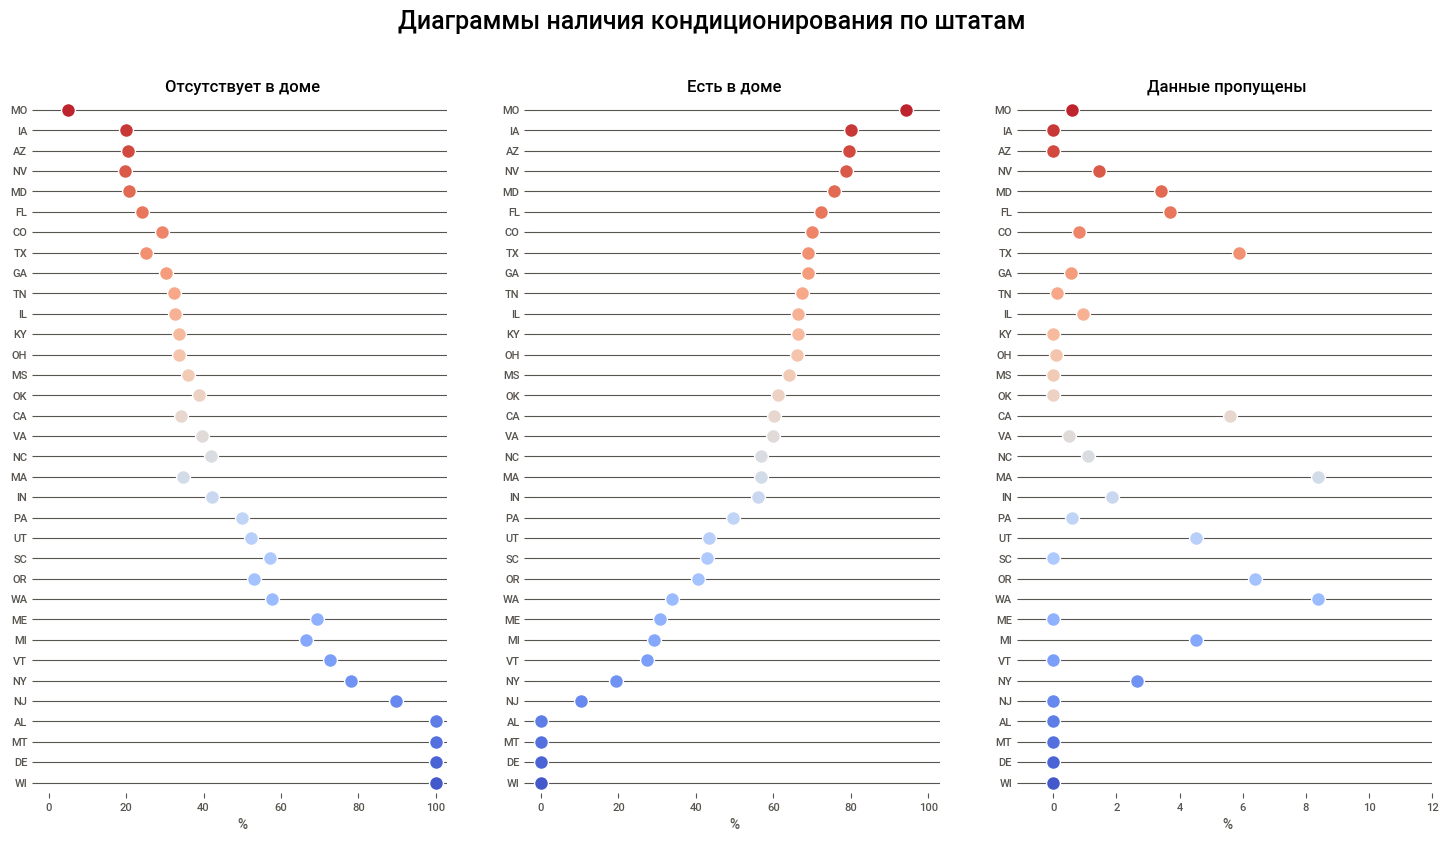

In [80]:
# Построим диаграммы, иллюстрирующие наличие/отсутствие кондиционирования
# в зависимости от штата
cross_diag('cooling')

С кондиционированием картина более явная. На диаграмме "Отсутствует в доме" интервал от 40% до 80% домов представлен именно холодными штатами.  

"Есть в доме" кондиционирование в жарких штатах в 60% - 80% случаев.  

И снова на диаграмме "Данные пропущены" высокие значения (от 4% до 9%) представлены большей частью холодными штатами, что так же может свидетельствовать, что значение None следовало трактовать, как отсутствие кондиционирования как такового. Но, поскольку, описания значений признаков у нас нет, оставим наши текущие предположения и посмотрим на последний признак - "parking".  

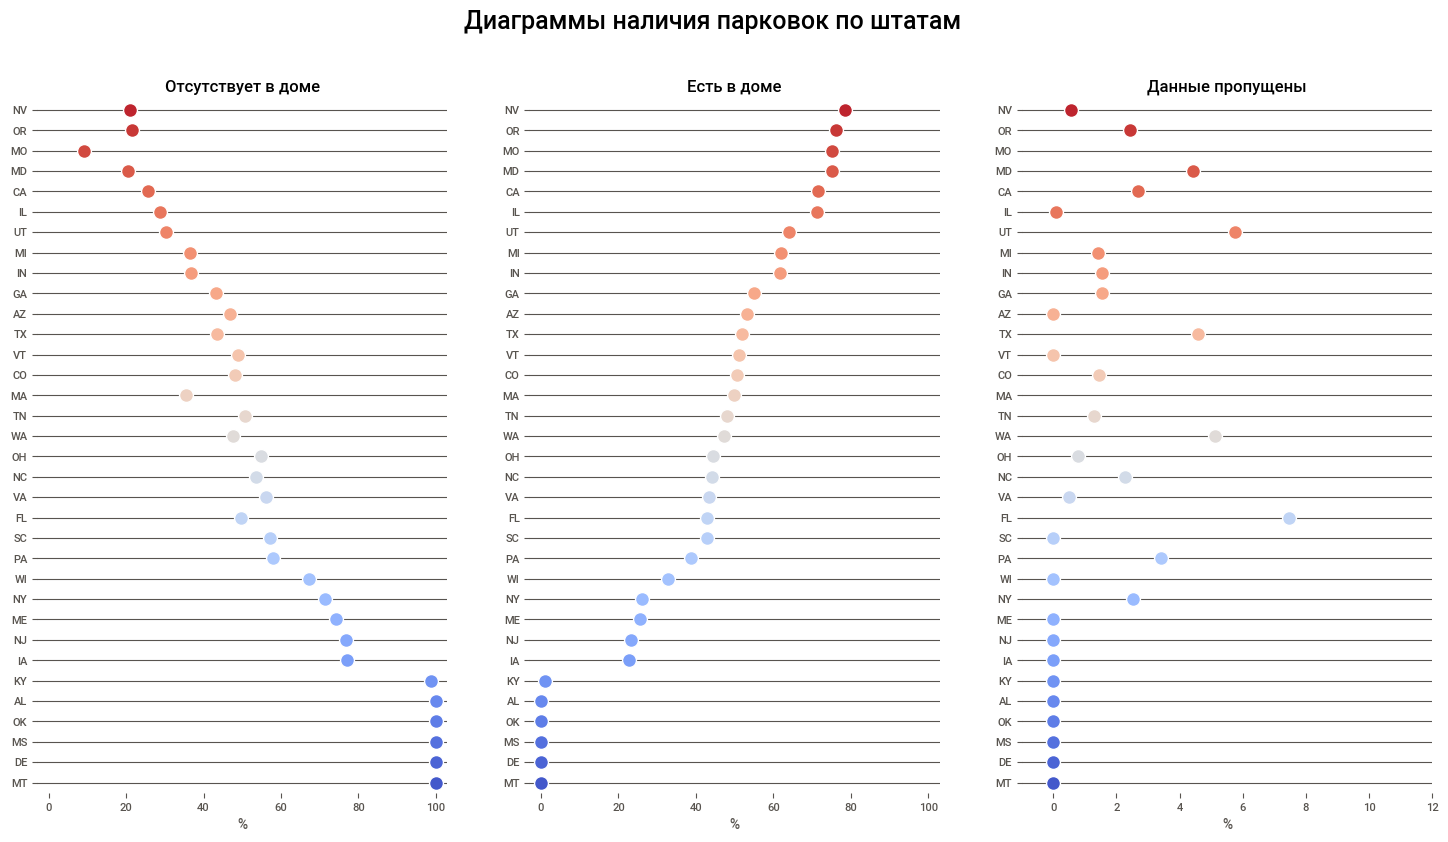

In [81]:
# Построим диаграммы, иллюстрирующие наличие/отсутствие парковочных мест
# в зависимости от штата
cross_diag('parking')

По признаку парковок не просматривается какого-либо тренда в зависимости от расположения дома в жарком или холодном штате. Как мы и предположили в начале, более правильным представляется группировка по городам, т.к. именно размер города и его застройка (частные дома или многоквартирные небоскребы) определяют ситуацию с парковочными местами.  

Напомним, что данный шаг с построением диаграмм нужен был, чтобы решить, как заполнять пустые значения.
Предположим, что дополнительное оборудование увеличивает стоимость дома. Следовательно, если дом с пропущенным значением по своей цене ближе к тем 72%, где отопление установлено, то логично будет пропущенное значение заменить на положительное значение "Есть в доме" ('Yes' в df). Если же дом по цене ближе к тем, где нет отопления, значит в его признаке мы поставим отрицательное значение "Отсутствует в доме" ('No' в df).  

Таким образом, следующим шагом, мы сгруппируем все записи по признаку штата, признаку типа недвижимости (потому что в односемейном доме может быть парковка, а в квартире - нет) и заполняемому признаку ("heating" или "cooling"). Затем будем вычитать стоимость дома с пропущеным значением признака из медиан образованных групп. Наименьшая по модулю разница и определит, какое значение для конкретного типа жилья в конкретном штате записать вместо пропуска.  

In [82]:
# Функция заполнения пропусков heating и cooling
def fill_heat_cool(state: pd.Series,
                   p_type: pd.Series,
                   target: pd.Series,
                   state_gr: pd.DataFrame):
    """Функция получает на вход три признака: штат, тип собственности,
    цену дома, которые сравнивает с медианой сгруппированного
    df и возвращает вектор значений для заполнения
    признака с пропусками: heating или cooling.

    Args:
        state (pd.Series): признак штата
        p_type (pd.Series): признак типа собственности
        target (pd.Series): признак целевой - цена дома
        state_gr (pd.DataFrame): df с медианами

    Returns:
        pd.Series: вектор заполненных значений
    """
    # Вычисляем разницу с медианами по штату, типу собственности
    # и значению наличия/отсутствия удобства, сортируем по
    # возрастанию от самой маленькой разницы по модулю, сохраняем
    # Series в result
    result = abs(state_gr[state][p_type] - target).nsmallest()

    try:
        if result.index[0] == 'missing': # если минимальная разница - с "missing"
            result = result.index[1] # то берем второй элемент Seires
        elif result.index[0] in ['Yes', 'No']: # если на первом месте "Yes" или "No"
            result = result.index[0] # то присваиваем их
        else:
            result = np.NaN # иначе присваиваем NaN для поиска ошибки
    except: # обработка непредвиденной ошибки индексации
        result = np.NaN

    # Возвращаем результат
    return result

In [83]:
# Сгруппируем данные по штатам, типам и заполняемому признаку, вычислим медиану цены
state_heat_gr = df.groupby(['state', 'propertyType', 'heating'])['target'].median()
state_cool_gr = df.groupby(['state', 'propertyType', 'cooling'])['target'].median()

# Сохраним индексы записей, в которых пропущены значения
ind_heat = df[df['heating'] == 'missing'].index
ind_cool = df[df['cooling'] == 'missing'].index

# Заполняем пропущенные значения в признаке heating
df.loc[ind_heat, 'heating']\
    = df.loc[ind_heat, ['state', 'propertyType', 'target']]\
    .apply(lambda x: fill_heat_cool(*x, state_heat_gr), axis=1)

# Заполняем пропущенные значения в признаке cooling
df.loc[ind_cool, 'cooling']\
    = df.loc[ind_cool, ['state', 'propertyType', 'target']]\
    .apply(lambda x: fill_heat_cool(*x, state_cool_gr), axis=1)

# Проверяем, что все пропуски заполнены
print('Количество пропусков в признаке heating:',
    df['heating'].isna().sum() + df[df['heating'] == 'missing'].shape[0])
print('Количество пропусков в признаке cooling:',
    df['cooling'].isna().sum() + df[df['cooling'] == 'missing'].shape[0])

del state_heat_gr, state_cool_gr, ind_heat, ind_cool

Количество пропусков в признаке heating: 0
Количество пропусков в признаке cooling: 0


Итак, пропуски в признаках "heating" и "cooling" мы заполнили на основании группировки по штатам.  

Для заполнения пропусков в признаке "parking" воспользуемся группировкой по городам. (Иллюстрировать это не будет, т.к. штатов в нашем df - 34, а городов - 1.8 тыс.: это будет малоинформативно.)    

In [84]:
# Функция заполнения пропусков в parking
def fill_parking(city: pd.Series,
                 p_type: pd.Series,
                 target: pd.Series,
                 city_gr: pd.DataFrame,
                 df: pd.DataFrame):
    """Функция получает на вход три признака: город, тип собственности,
    цену дома, которые сравнивает с медианой сгруппированного
    df и возвращает вектор значений для заполнения
    признака с пропусками parking.

    Args:
        city (pd.Series): признак города
        p_type (pd.Series): признак типа собственности
        target (pd.Series): признак целевой - цена дома
        city_gr (pd.DataFrame): датафрейм с медианами

    Returns:
        pd.Series: вектор заполненных значений
    """
    # Вычисляем разницу с медианами по городу, типу собственности
    # и значению наличия/отсутствия удобства, сортируем по
    # возрастанию от самой маленькой разницы по модулю, сохраняем
    # Series в result
    result = abs(city_gr[city][p_type] - target).nsmallest()

    try:
        if result.index[0] == 'missing': # если минимальная разница - с "missing"
            result = result.index[1] # то берем второй элемент Seires, если он есть
        elif result.index[0] in ['Yes', 'No']: # если на первом месте "Yes" или "No"
            result = result.index[0] # то присваиваем их
        else:
            result = np.NaN # иначе присваиваем NaN для поиска ошибки
    except: # если в result было единственное значение - missing, возникнет ошибка индексации
        result = df[df['city'] == city].parking.mode()[0] # присваиваем моду по городу
        if result == 'missing':
            result = np.NaN # если во всем городе - только missing, заменяем на NaN

    # Возвращаем результат
    return result

In [85]:
# Сгруппируем данные по городам, типам и заполняемому признаку, вычислим медиану цены
city_park_gr = df.groupby(['city', 'propertyType', 'parking'])['target'].median()

# Сохраним индексы записей, в которых пропущены значения
ind_park = df[df['parking'] == 'missing'].index

# Заполняем пропущенные значения в признаке parking
df.loc[ind_park, 'parking']\
    = df.loc[ind_park, ['city', 'propertyType', 'target']]\
    .apply(lambda x: fill_parking(*x, city_park_gr, df), axis=1)

# Удаляем возможные оставшиеся пропуски
# (порядка 17 городов не имеют информации о парковках)
nan_left = df['parking'].isna().sum()
if nan_left != 0:
    print(f'{nan_left} пропусков заполнить не получилось - к удалению.')
    df.dropna(axis=0, subset='parking', inplace=True) # удаляем строки с пропусками

# Проверяем, что все пропуски заполнены
print('Количество пропусков в признаке parking:',
    df['parking'].isna().sum() + df[df['parking'] == 'missing'].shape[0])

del city_park_gr, ind_park, nan_left

19 пропусков заполнить не получилось - к удалению.
Количество пропусков в признаке parking: 0


### 5.4. Обработка признака "lotsize"  

Этот признак иногда содержит размер участка. Очистим его, оставив только цифры, и затем попробуем использовать для заполнения пропущенных значений в признаке "sqft".  

Сразу заметим, что в "lotzise" часто встречаются площади в акрах. Акр равен 43,5 тыс. квадратных футов. Минимальное значение в признаке - 26 акров, что превышает 1 млн. квадратных футов - таких объектов нет в нашем датафрейме. Таким образом, не представляется возможным установить, к чему относится эта площадь - но, однозначно не к продаваемой недвижимости. Поэтому все ячейки, содержащие "acr" мы заменим на "No Data" для простоты последующей обработки.  

In [86]:
# Сперва избавимся от запятых и точек, отделяющих тысячные разряды
df['lotsize'] = df['lotsize'].str.replace('.', '')
df['lotsize'] = df['lotsize'].str.replace(',', '')

# Затем избавимся от всех величин площадей в акрах
ind = df[df['lotsize'].str.contains('acr', case=False) == True].index
df.loc[ind, 'lotsize'] = 'No Data'

# Наконец воспользуемся написанной ранее функцией, чтобы выделить квадратные футы
df['lotsize'] = df['lotsize'].apply(sqft_num).astype(float)

In [87]:
# Задаем маски непустых и ненулевых значений
m1 = df.sqft.isna() == False
m2 = df.sqft != 0
m3 = df.lotsize.isna() == False
m4 = df.lotsize != 0

# Сохраняем индексы таких записей и выводим размерность
ind = df[m1 & m2 & m3 & m4].index
print('Записей с непустым sqft и lotsize:', len(ind))

Записей с непустым sqft и lotsize: 178556


In [88]:
# Создадим признак отношения и заполним его, где возможно
df['sqft_ratio'] = 0
df.loc[ind, 'sqft_ratio'] = df.loc[ind, 'lotsize'] / df.loc[ind, 'sqft']

# Сгруппируем коэффициент отношения по типу недвижимости и вычислим медиану
ratio_gr = df.loc[ind].groupby('propertyType')['sqft_ratio'].median()
display('Отношение lotsize к sqft среди непустых значений:', ratio_gr.round(2))

'Отношение lotsize к sqft среди непустых значений:'

propertyType
Condo            1.00
Land             2.97
Multifamily      1.74
Single family    3.59
Townhouse        1.02
Name: sqft_ratio, dtype: float64

Очевидно, размер участка земли "Land" больше площади дома "sqft", который можно на нем построить, поэтому мы видим медианный коэффициент в размере 2.97.  

Примерно в половину меньше коэффициент у односемейных домов. По всей вероятности, он появился из-за дорогих домов, имеющих большую территорию (однажды построенных на как раз таких участках "Land").  

Наименьший коэффициент - у квартир "Condo" и "Townhouse", которые располагаются в городах, где придворовая территория невелика. Все выглядит довольно логично.  

Однако в число записей, которые мы сможем заполнить вычисленным значением, входят большей частью в записи, помеченные как выбросы при обработке "target", то есть большая часть заполненных нами значений будет удалена. А кроме этого, вычисленные значения иногда получаются очень неточными (по сравнению с делением "target" на "price_sqft", как мы увидим дальше), поэтому, как не обидно, но от идеи использования этого признака нам придется отказаться.  

In [89]:
# Удаляем ненуженые признаки
df = df.drop(['lotsize', 'sqft_ratio'], axis=1)

del ratio_gr, ind, m1, m2, m3, m4 # очищаем память

### 5.5. Обработка признака "price_sqft"  

Очистим признак от текстовых значений, сохранив только числа - цену за квадратный фут.  

Нули заменим на np.NaN для удобства дальнейшей работы. А также сразу удалим (обозначим как np.NaN) такие значения, которые совпадают со стоимостью всей недвижимости.  

Затем вычислим площадь недвижимости, разделив ее стоимость "target" на цену за кв. фут "price_sqft" и сохраним в признак "true_sqft". Из этого признака заменим пропуски в признаке "sqft".

In [90]:
# Удаляем знак $, запятые и точки, отделяющих тысячные разряды
df['price_sqft'] = df['price_sqft'].str.replace('$', '')
df['price_sqft'] = df['price_sqft'].str.replace(',', '')
df['price_sqft'] = df['price_sqft'].str.replace('.', '')

# Наконец воспользуемся написанной ранее функцией, чтобы выделить цену за квадратный фут
df['price_sqft'] = df['price_sqft'].apply(sqft_num).astype(float)

# Обозначим как пропуск цены, равные стоимости участка, а также все нули
ind = list(df[df['price_sqft'] == df['target']].index)
ind.extend(list(df[df['price_sqft'] == 0].index))
df.loc[ind, 'price_sqft'] = np.NaN

In [91]:
# Задаем маски пустых и нулевых значений
m1 = df.sqft.isna() == True
m2 = df.price_sqft.isna() == True

print('Непустые значения price_sqft:', df[~m2].shape[0])
print('Пустые значения sqft:', df[m1].shape[0])
print('Пересечение непустых price_sqft и пустых sqft:', df[m1&~m2].shape[0])

Непустые значения price_sqft: 307207
Пустые значения sqft: 52443
Пересечение непустых price_sqft и пустых sqft: 1246


In [92]:
# Сохраняем индексы записей с непустыми ячейками price_sqft
ind = df[~m2].index
# Вычисляем площадь дома, а также разницу с признаком sqft
df.loc[ind, 'true_sqft'] = (df.loc[ind, 'target'] / df.loc[ind, 'price_sqft']).astype(int)
df.loc[ind, 'sqft_dif'] = abs(df.loc[ind, 'sqft'] - df.loc[ind, 'true_sqft'])

# Сохраняем индексы пересечения
ind = df[m1&~m2].index
# Заполняем пропуски в sqft с помощью вычисленных значений
df.loc[ind, 'sqft'] = df.loc[ind, 'true_sqft']

Видим, что десериализованный признак "price_sqft" не особо помог нам в заполнении пропусков в признаке "sqft" (всего 1246 записей из 52443)

### 5.6. Фильтрация записей по признакам "sqft" и "price_sqft"   

Следует убрать выбросы и пустые значения в ключевом признаке sqft.  

С этой целью мы проверим на выбросы с помощью метода z-отклонений два признака:  
- "sqft",  
- "price_sqft".
Определенные выбросы пометим флагами в соответствующих новых признаках.  

Таким образом, вместе с созданным ранее столбцом выбросов "outliers" для целевого признака "target" мы отфильтруем такие объявления, которые выбиваются из общей массы по одной из этих независимых характеристик (независимых потому, что в df значения, сохраненные в этих признаках, могут быть не связаны).  

Мы также посмотрим, как распределена ошибка расчетной площади с имевшейся в df (новый признак "sqft_dif").  

In [93]:
# Функция вывода на экран гистограммы распределения признака
def draw_hist(df: pd.DataFrame,
              feat: str,
              left: int,
              right: int,
              log_scale: bool = True,
              bins: int = 50):
    """Функция выводит на экран гистограмму распределения признака
    (при необходимости в логарифмическом масштабе), отрисовывает
    нижнюю и верхнюю границы отклонений.

    Args:
        df (pd.DataFrame): исходный df
        feat (str): иллюстрируемый признак
        left (int): кол-во сигм для нижней границы
        right (int): кол-во сигм для верхней границы
        log_scale (bool: optional): переход к лог. масштабу, по умолчанию = True
        bins (int: optional): кол-во столбцов, по умолчанию = 50

    Returns:
        None: функция ничего не возвращает
    """

    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feat].min() > 0: # если значения признака больше 0
            log_target = np.log(df[feat])
        else:
            log_target = np.log(df[feat]+1) # иначе добавляем единицу
    else:
        log_target = df[feat]

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + right * log_target.std()
    lower_bound = log_target.mean() - left * log_target.std()

    # Строим гистрограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data = log_target,
        bins = bins
    );
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    histplot.set_title(f'Гистограмма для {feat}', fontsize=10);
    histplot.set_xlabel('');
    histplot.set_ylabel('');

    return

Число выбросов по методу z-отклонений для price_sqft: 4178
Результирующее число записей для price_sqft: 303029


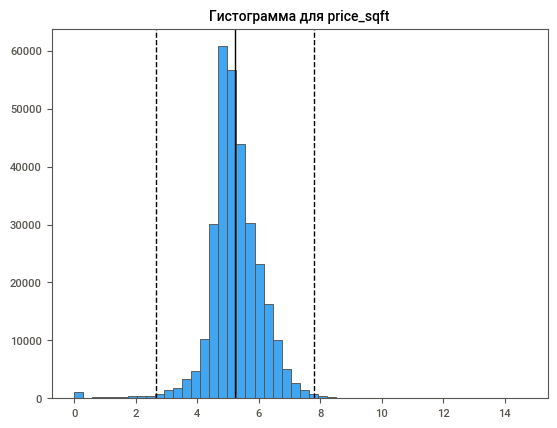

In [94]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'price_sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_price_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_price_sqft'] = 1

# Отрисуем гистограмму
draw_hist(df, feat, left, right)

Число выбросов по методу z-отклонений для sqft: 2244
Результирующее число записей для sqft: 317018


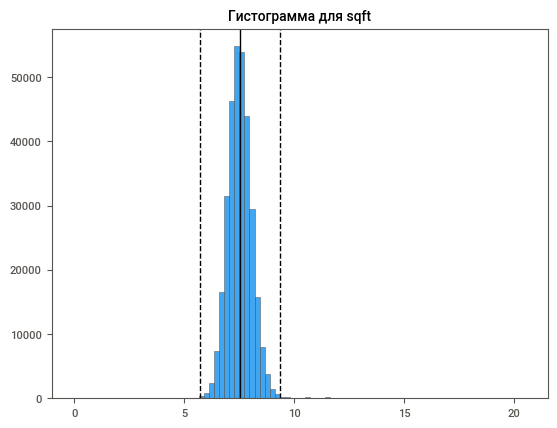

In [95]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_sqft'] = 1

# Отрисуем гистограмму
draw_hist(df, feat, left, right, bins=90)

In [96]:
# Объединяем все флаги выбросов по трем признакам в один
df['total_outliers'] = df['outliers'] + df['outliers_sqft'] + df ['outliers_price_sqft']
print('Всего к выбросам отнесено записей:', df[df['total_outliers'] > 0].shape[0])

Всего к выбросам отнесено записей: 22000


Число выбросов по методу z-отклонений для sqft_dif: 3086
Результирующее число записей для sqft_dif: 302875


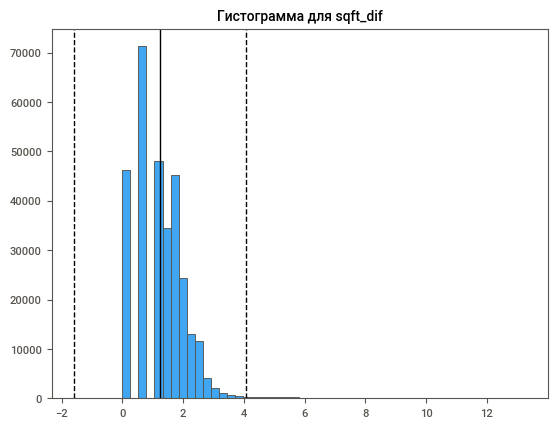

In [97]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft_dif'

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран (признак с флагами не создавали)
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')

# Отрисуем гистограмму
draw_hist(df, feat, left, right, log_scale=True)

Посмотрим, как разница между вычисленным значением площади и тем, чтобы было изначально в датафрейме "sqft_dif", распределилась по типам недвижимости.

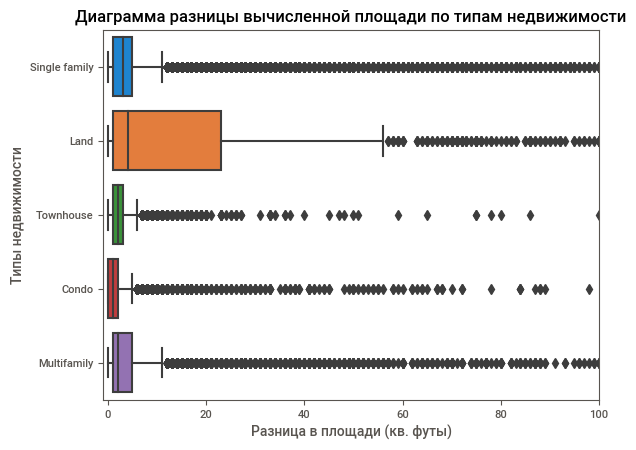

In [98]:
# Построим коробчатую диаграмму
boxplot = sns.boxplot(
    data = df,
    x = 'sqft_dif',
    y = 'propertyType'
);
boxplot.set(xlim=(-1, 100)); # ограничим диапазон из-за выбросов
boxplot.set_title('Диаграмма разницы вычисленной площади по типам недвижимости');
boxplot.set_xlabel('Разница в площади (кв. футы)');
boxplot.set_ylabel('Типы недвижимости');

Видно, что самое большое значение 1,5 межквартильных размаха приходится на тип "Land" - в райне 60 кв. футов. Примем за выбросы все значения разницы выше этого. Проверим, какое количество записей находятся по одну и по другую границу, а также сравним, какой процент из них входит в определенные нами выбросы по другим признакам.

In [99]:
print('Записей с разницей выше 60 кв. футов:', df[df['sqft_dif'] > 60].shape[0])
print('Записей с разницей меньше или равно 60 кв. футов:', df[df['sqft_dif'] <= 60].shape[0])

dif_in_out = round(df[(df['sqft_dif']>60)\
                      & (df['total_outliers']>0)].shape[0]\
                   / df[df['total_outliers']>0].shape[0]*100)

print(f'Доля записей с разницей выше 60 кв. футов в выбросах: {dif_in_out}%')

Записей с разницей выше 60 кв. футов: 2998
Записей с разницей меньше или равно 60 кв. футов: 302963
Доля записей с разницей выше 60 кв. футов в выбросах: 11%


В отобранные нами выбросы по признакам "sqft" и "price_sqft" попали лишь 11% записей, где разница между расчетной и исходной площадью превышает 60 кв. футов. При уменьшении разницы до 40 кв. футов  мы бы получили 13% вхождения. Таким образом, выбросы в признаке "sqft_dif" можно считать погрешностью в объеме всех выбросов. 

Также удалим записи, у которых площадь равна или превышает стоимость. Это не возможно априори, потому что означает, что квадратный фут стоит один доллар или меньше. Таких записей в нашем df немногим более 800.   

In [100]:
# Формируем список на удаление: выбросы и неадекватная площадь
ind = set(df[df['total_outliers'] > 0].index)
ind.update(df[df['sqft'] >= df['target']].index)
df = df.drop(list(ind), axis=0)

# Удалим ненужные признаки
df = df.drop(['outliers','outliers_sqft', 'outliers_price_sqft',
              'total_outliers', 'true_sqft', 'sqft_dif'], axis=1)

# Проверим, сколько пропусков остается
print(f'Все еще остается {df.sqft.isna().sum()} пропуска в признаке sqft')
print(f'Это составляет {round(df.sqft.isna().sum()/df.shape[0]*100,2)}% датафрейма')

# Удаляем записи с оставшимися пропусками
df.dropna(axis=0, subset='sqft', inplace=True)
print('Эти записи удалены')

Все еще остается 44623 пропуска в признаке sqft
Это составляет 12.81% датафрейма
Эти записи удалены


Теперь, когда мы удалили выбросы, мы можем вернуться к построение диаграммы зависимости стоимости недвижимости от ее площади.  

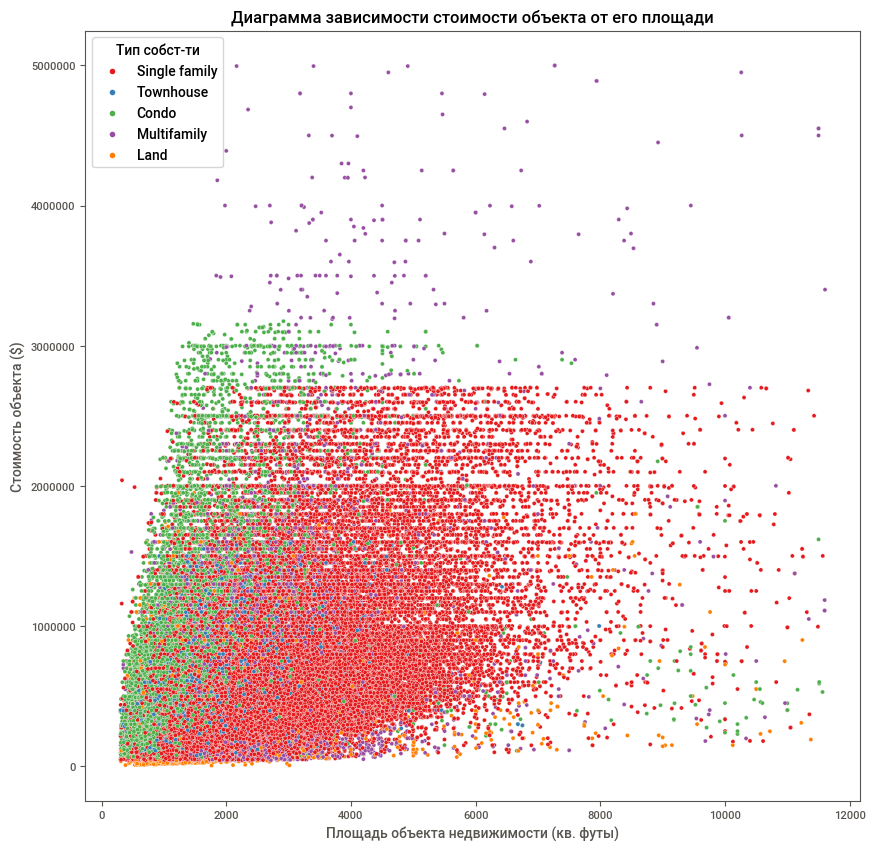

In [101]:
# Построим диаграмму зависимости стоимости от площади
fig = plt.figure(figsize=(10, 10))
scatterplot = sns.scatterplot(
    data = df,
    x = 'sqft',
    y = 'target',
    hue = 'propertyType',
    palette = 'Set1'
);
scatterplot.set_title('Диаграмма зависимости стоимости объекта от его площади');
scatterplot.set_xlabel('Площадь объекта недвижимости (кв. футы)');
scatterplot.set_ylabel('Стоимость объекта ($)');
scatterplot.legend(title = 'Тип собст-ти');

Несмотря на удаление выбросов, диаграмма не стала более информативной, но все же попробуем уловить какие-то закономерности на этой диаграмме.  

Ожидаемо с увеличенем площади растет и цена, хотя есть большие по площади объекты, которые остаются дешевыми, будем считать это особенностью этих объектов (вдруг там было совершено преступление, не все хотят брать дома с такой историей).  

Четко просматриваются горизонтальные линии среди всех типов недвижимости - цены за дом округлены. Совсем мало остается объектов после \$275 - 300 тыс. И они в основном принадлежат типу многосемейных домов.  

В распределении не просматривается строгая линейная зависимость, вот почему применение модели линейной регрессии будет недостаточно для получения хороших результатов.  

### 5.7. Обработка признака "school"  

В этом признаке содержится сериализованный словарь данных о близлежащих школах:  
- рейтинг школы по десятибальной шкале,  
- расстояние до школы в милях,  
- классы школы (начальные, средние и др.),  
- название школы.  

Понятно, что чем выше рейтинг и чем ближе школа, тем лучше. Поэтому составим совокупный рейтинг в виде среднего арифметического рейтингов, деленных на расстояния. Таким образом, высокий рейтинг школы компенсирует большое расстояние до нее. Зато школа с рейтингом ниже, но по соседству, тоже продемонстрирует высокий совокупный рейтинг.  

Вместе с тем, наш совокупный рейтинг не будет отражать, какое количество школ расположено пососедству от объекта недвижимости. Поэтому, чтобы не терять эту информацию, выделим еще один признак - количество школ. Это будет не что иное, как длина списка расстояний.  

Напишем несколько функций: для десериализации признака "schools", для преобразования текстовых списков к числовым и для вычисления среднего арифметического нашего рейтинга.  

In [102]:
# Функция десериализации признака school
def deserialize_school(s: str) -> pd.Series:
    """Функция возвращает значения словаря, который находится
    в сериализованном виде в строке s.

    Args:
        s (str): строка с сериализованным словарем

    Returns:
        pd.Series: список из значений словаря в виде объекта Series
    """

    # Десериализуем строку в словарь и сразу сохраним его единственое значение
    result = eval(s)[0]

    # В единственном значении словаря хранится словарь из 3 элементов,
    # каждый из которых представлен списками (за исключением второго - data,
    # у которого два списка обернуты в словарь).
    # Вернем рейтинги и расстояние до школ
    rating = result['rating']
    distance = result['data']['Distance']

    # Возвращаем списки в виде объекта Series
    return pd.Series([rating, distance])

In [103]:
# Функция преобразования списка строк в список числовых значений
def clear_list(str_list: list) -> list:
    """Функция преобразует список строковых значений,
    в список числовых. При этом функция выделяет первое
    число в рейтинге (4/10 -> 4) и расстояние обозначенное
    с помощью "mi".

    Args:
        str_list (list): список строковых значений

    Returns:
        list: список значений, преобразованных в числовой вид
    """

    # Скомпилируем паттерны для поиска в признаках rating и dist
    p_rat = re.compile('(\d+)/?')
    p_dis = re.compile('(\d+\.?\d*)\s*mi')

    if len(str_list) == 0: # если в ячейке пустой список
        result = np.NaN
    elif 'NR' in str_list: # если в списке содержится 'NR'
        result = [int(r) if r.isdigit() else np.NaN for r in str_list]
    elif len(list(filter(p_dis.search, str_list))) > 0: # если в списке содержится расстояние
        result = [float(p_dis.search(r).group(1)) if p_dis.search(r)\
                  else np.NaN for r in str_list]
    elif len(list(filter(p_rat.match, str_list))) > 0: # если в списке рейтинг со слэшами
        result = [int(p_rat.match(r).group(1)) if p_rat.match(r)\
                  else np.NaN for r in str_list]
    else:
        result = np.NaN # в крайнем случае вернем np.NaN

    # Возвращаем преобразованный список
    return result

In [104]:
# Функция вычисления среднего арифметического списков
def mean_lists(rating: list, dist: list) -> float:
    """Функция вычисляет среднее арифметическое двух списков,
    состоящих из числовых значений. Вначале она делит рейтинги
    на расстояния, затем получившийся список частных преобразует
    в объект pd.Series и вычисляет среднее арифметическое.
    Перед делением функция заменяет нулевые расстояния на 0.1
    (минимальное встречающееся в df), чтобы избежать
    бесконечности (np.inf) в ответе.

    Args:
        rating (list): список рейтингов школ
        dist (list): список расстояний до школ

    Returns:
        float: средне-арифметический коэффициент
    """

    if type(rating) == list and type(dist) == list:
        # Нулевые расстояния заменим на минимальные, чтобы избежать inf
        dist = list(map(lambda x: 0.1 if x==0 else x, dist))
        mult = list(np.divide(rating, dist)) # делим рейтинг на расстояние
        result = pd.Series(mult).mean() # вычисляем ср. арифм.
    else:
        result = np.NaN # если на вход поданы не списки, вернем np.NaN

    # Возвращаем результат работы функции
    return result

In [105]:
# Десериализуем признак schools
df[['sch_rating', 'sch_dist']] = df['schools'].apply(deserialize_school)

# Генерируем два новых признака с рейтингами и расстояниями до школ
df['sch_rating'] = df['sch_rating'].apply(clear_list)
df['sch_dist'] = df['sch_dist'].apply(clear_list)

# Вычисляем совокупный рейтинг
df['sch_rat_dist'] = df[['sch_rating', 'sch_dist']]\
                     .apply(lambda x: mean_lists(*x), axis=1).round()

# Сохраняем в отдельный признак количество школ
try:
    df['sch_number'] = df['sch_dist']\
                   .apply(lambda x: len(x) if x is not np.NaN else np.NaN)
except: # после чтения из файла список хранится как строка, что вызывает ошибку
    df['sch_number'] = df['sch_dist']\
                      .apply(lambda x: len(eval(x)) if x is not np.NaN else np.NaN)

In [106]:
# Взглянем на описание созданного нами признака совокупного рейтинга
df['sch_rat_dist'].describe()

count    300681.000000
mean          6.025688
std           6.560195
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         333.000000
Name: sch_rat_dist, dtype: float64

In [107]:
# А также посмотрим на количество школ, которые окружают дома
df['sch_number'].describe()

count    301388.000000
mean          4.180445
std           4.430283
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          65.000000
Name: sch_number, dtype: float64

Как видим, медианный рейтинг равен примерно 4 единицам, а ТОП-10 представлен всеми значениями от 1 до 10 включительно.

Встречаются и аномальные значения вплоть до 333. Есть такие объекты недвижимости, где школа (по ее названию и расстоянию до нее) удалена достаточно сильно. Может быть, ребенок ездит учиться в другой город 

Что касается количества школ, то, как правило, родители могут выбрать из 3-4. Правда, есть случаи, когда в районе находится 65 школ (вопрос расстояния до них).  

Заполним пропуски медианой, характерной для типа недвижимости, т.к. для квартир в городах, школы должны быть ближе, чем для частных домов в небольших городках.  

In [108]:
# Вычислим медиану совокупного рейтинга для каждого из типов жилья
proper_sch_rat_med = df.groupby('propertyType')['sch_rat_dist'].median()
# Вычислим медиану количества школ для каждого из типов жилья
proper_sch_num_med = df.groupby('propertyType')['sch_number'].median()

# Запускаем цикл по всем типам недвижимости
for p in proper_sch_rat_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['sch_rat_dist'].isna() == True # маска по пропускам в sch_rat_dist
    mask3 = df['sch_number'].isna() == True # маска по пропускам в sch_number
    ind = df[mask1 & mask2]['sch_rat_dist'].index # сохраняем индекс
    df.loc[ind, 'sch_rat_dist'] = proper_sch_rat_med[p] # присваиваем медиану рейтингу

    ind = df[mask1 & mask3]['sch_number'].index # сохраняем индекс
    df.loc[ind, 'sch_number'] = proper_sch_num_med[p] # присваиваем медиану кол-ву школ

# Проверяем результаты заполнения
print('Осталось пропущенных значений в признаке sch_rat_dist:',
      df['sch_rat_dist'].isna().sum())
print('Осталось пропущенных значений в признаке sch_number:',
      df['sch_number'].isna().sum())

# Удаляем ненужные более признаки
df = df.drop(['schools', 'sch_rating', 'sch_dist'], axis=1)

Осталось пропущенных значений в признаке sch_rat_dist: 0
Осталось пропущенных значений в признаке sch_number: 0


### 5.8. Генерация признака столицы штата "state_cap"  

Ранее мы выдвинули гипотезу, что стоимость недвижимости в столицах штатов может отличаться от прочих городов. Чтобы проверить ее, создадим новый признак. Для этого скачаем список всех штатов с их аббревиатурами и столицами и добавим к нашему df. Выставим маркер того, расположен ли объект недвижимости в столице штата или нет и посмотрим на результаты.  



In [109]:
# Определяем адрес страницы с сокращениями штатов и выполняем GET-запрос
url = 'https://bigdave44.com/features/the-mine/us-states-abbreviations-capitals-nicknames/'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с названием, аббревиатурой и столицей штата
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, аббревиатура, столица
states_cap = [r_d.text for r_d in raw_data][4:203]

# Фомируем датафрем из названий аббревиатур штатов и столиц
cap_df = pd.DataFrame(list(zip(states_cap[1::4],
                               states_cap[2::4])),
                      columns = ['state', 'capital'])
# Переводим все столицы в нижний регистр (как в датафрейме)
cap_df['capital'] = cap_df['capital'].str.lower()

# Добавляем получившийся датафрейм к основному
df = pd.merge(
    left = df,
    right = cap_df,
    on = 'state',
    how = 'left'
)

In [110]:
# Генерируем признак нахождения в столице штата
df['in_st_capital'] = df[['city', 'capital']]\
                      .apply(lambda x: 1 if x.city == x.capital else 0, axis=1)

# Проверим, сколько объектов расположены в столицах штатов
obj = df['in_st_capital'].sum()
shr = round(obj / df.shape[0] * 100)
print(f'В столицах расположено {obj} объектов, что составляет {shr}% от df.')

# Удаляем ненужный столбец и чистим память
df = df.drop('capital', axis=1)
del url, response, page, raw_data, states_cap, cap_df, obj, shr

В столицах расположено 23844 объектов, что составляет 8% от df.


Доля объектов в столицах штатов невелика, больше похожа на погрешность. Интересно посмотреть, как этот признак повлияет на стоимость недвижимости.  

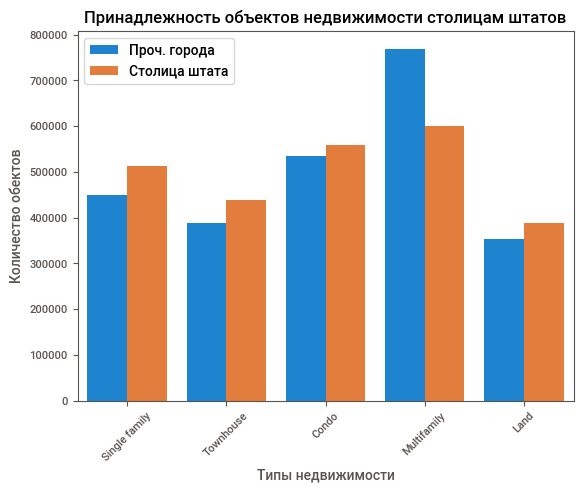

In [111]:
# Проиллюстрируем, наконец, нашу гипотезу
barplot = sns.barplot(
    data = df,
    x = 'propertyType',
    y = 'target',
    hue = 'in_st_capital',
    errorbar = None
);
barplot.set_title('Принадлежность объектов недвижимости столицам штатов');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество обектов');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);
barplot.legend(labels=['Проч. города', 'Столица штата']);

На диаграмме видно, что почти все объекты недвижимости, кроме многосемейных домов, чаще располагаются в столицах штатов. Отклонение незначительное.

Учитывая диаграмму особых ярко-выраженных трендов не выделено. Таким образом, данный признак не оказывает существенного влияния на модель.  

### 5.9. Кодирование признаков  

Приступим к подготовке данных к подаче на вход моделям обучения. И начнем с кодирования признаков. Удалим не нужные более признаки. Затем категориальные преобразуем в числовые:  
- где просто, вручную заменим бинарные значения на 1 и 0,  
- в остальных случаях прибегнем к помощи кодировщиков.  

In [112]:
# Удаляем ненужные признаки
df = df.drop(['street', 'homeFacts', 'city', 'price_sqft'], axis=1)

# Кодируем признаки с бинарными значениями
df['heating'] = df['heating'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['cooling'] = df['cooling'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['parking'] = df['parking'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

# Удаляем записи с оставшимися пропусками
df.dropna(inplace = True)

# Отобразим кол-во уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        df.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status           5
propertyType     5
state           33
stories          4
dtype: int64

In [113]:
# Создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType', 'stories']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df[oh_cols])
# Присоединяем к датафрейму закодированные признаки
df = pd.concat([df, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df[['state']])
# Присоединяем к датафрейму закодированные признаки
df = pd.concat([df, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер датафрейма
df = df.drop(['status', 'propertyType', 'stories', 'state'], axis=1)
print('Размер получившегося датафрейма:', df.shape)

Размер получившегося датафрейма: (303835, 31)


### 5.10. Оценка мультиколлинеарности признаков  

Проверим, нет ли сильной связи между признаками нашего датафрейма по методу Пирсона, особенно после генерации дополнительных.  

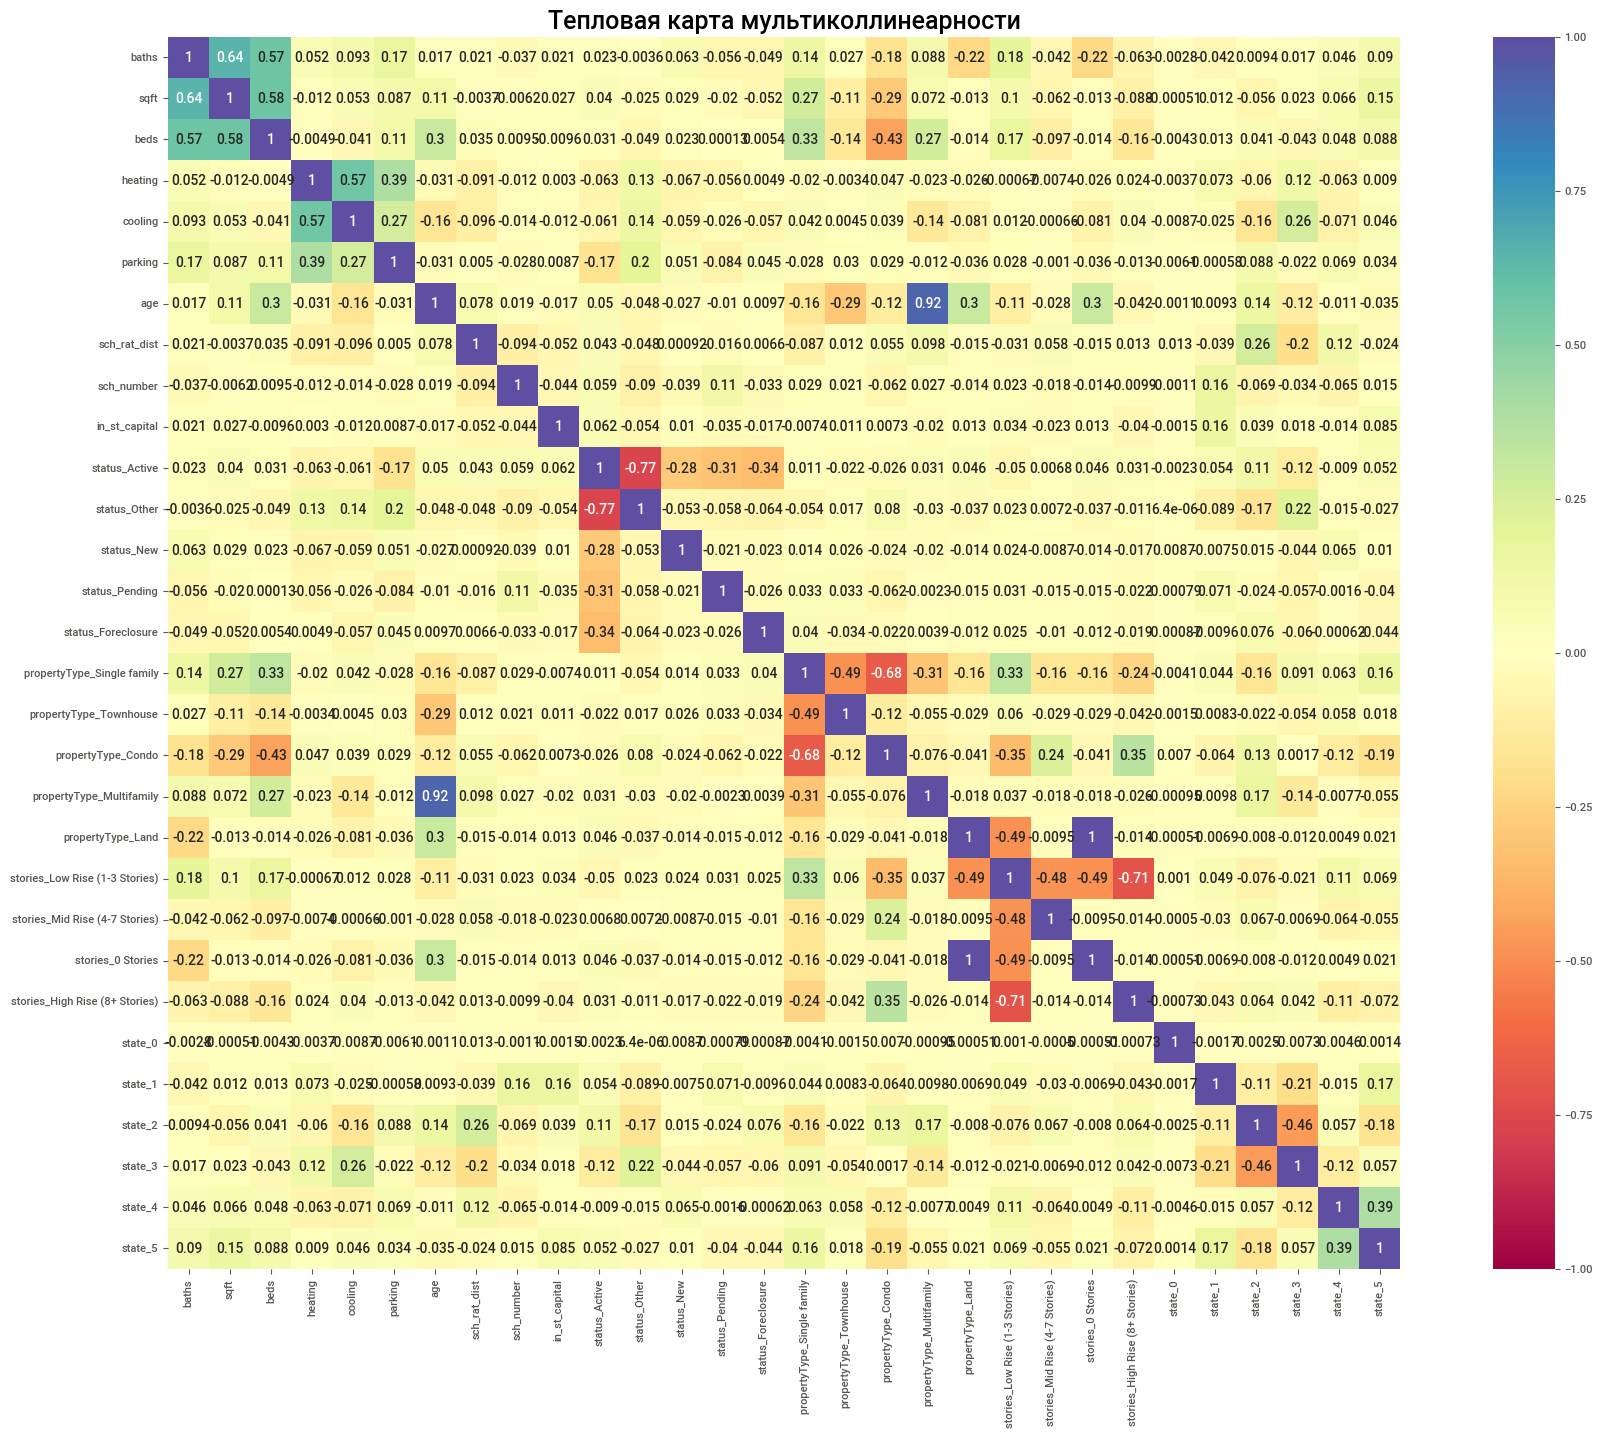

In [114]:
# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = df.drop('target', axis=1).corr(method='pearson'),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Spectral',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Абсолютная связь признаков "propertyType_Land" и "stories_0 Stories" объясняется тем, что на этапе очистки присвоили данному типу недвижимости категорию нулевых этажей.  
Поскольку недвижимости с нулем этажей это только участки, то можно избавиться от признака "stories_0 Stories". Все остальные можно оставить.

### 5.11. Оценка значимости и отбор признаков  

Спомощью SelectKBest отберем 20 лучших признаков из 29. Затем проведем хи-тест и тест ANOVA для категориальных и непрерывных признаков.  

После этого примем обоснованное решение, какие признаки удалять, а какие оставить в итоговых выборках.   

#### Отбор лучших признаков с помощью SelectKBest

In [115]:
# Создаем объект класса SelectKBest
kbest = SelectKBest(score_func=f_regression, k=20)

# Подгоняем его под данные и получаем список лучших 20 признаков
kbest.fit(df.drop('target', axis=1), df['target'])
kbest_columns = kbest.get_feature_names_out()

# Посмотрим, какие признаки не вошли в число лучших
display('Не вошли в число лучших признаков:',
        set(df.drop('target', axis=1).columns).difference(set(kbest_columns)))

'Не вошли в число лучших признаков:'

{'cooling',
 'in_st_capital',
 'propertyType_Land',
 'state_0',
 'status_Active',
 'status_New',
 'status_Other',
 'status_Pending',
 'stories_0 Stories',
 'stories_Mid Rise (4-7 Stories)'}

Метод SelectKBest предложил удалить "propertyType_Land" и "stories_0 Stories" и сгенерированный "in_st_capital". Проверим еще 

#### Тест хи-квадрат для категориальных признаков  

In [116]:
# Разделим все признаки на два списка: категориальные и непрерывные
cat_cols = ['baths', 'beds', 'heating','cooling', 'parking',
            'in_st_capital', 'status_Active', 'status_Other',
            'status_New', 'status_Pending', 'status_Foreclosure',
            'propertyType_Single family', 'propertyType_Townhouse',
            'propertyType_Condo', 'propertyType_Multifamily', 'propertyType_Land',
            'stories_Low Rise (1-3 Stories)', 'stories_Mid Rise (4-7 Stories)',
            'stories_0 Stories', 'stories_High Rise (8+ Stories)', 'state_0',
            'state_1', 'state_2', 'state_3', 'state_4', 'state_5']

num_cols = ['sqft', 'age', 'sch_rat_dist', 'sch_number']

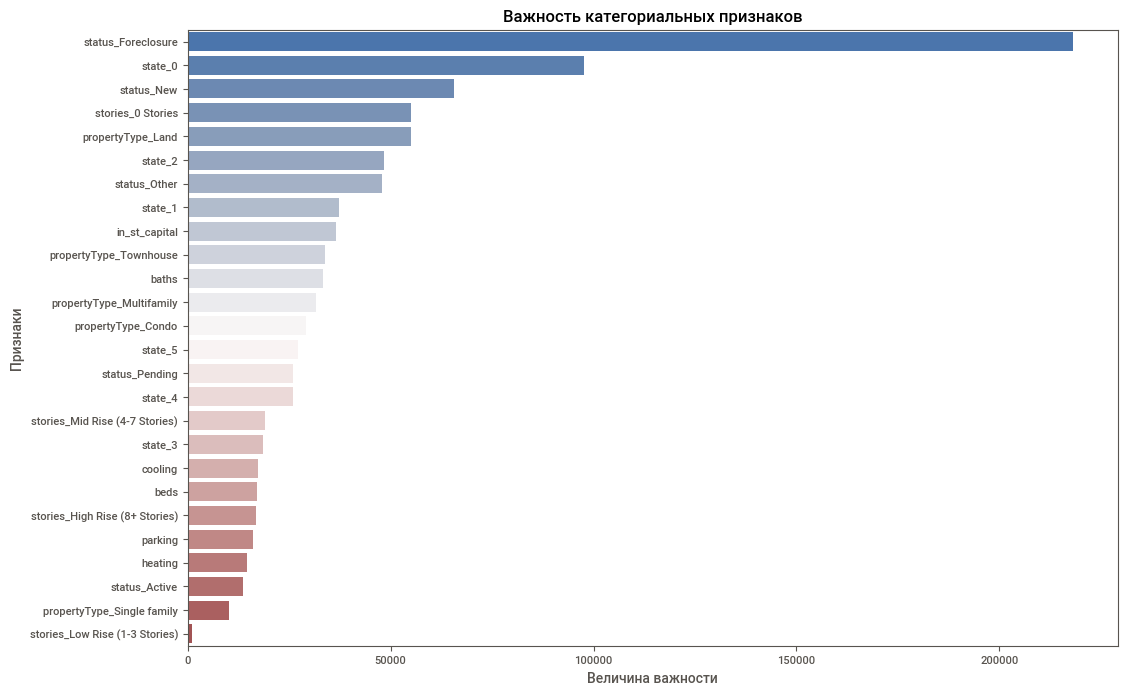

In [117]:
# Воспользуемся тестом хи-квадрат и проиллюстрируем его результаты
imp_cat = pd.Series(chi2(df[cat_cols], df.target)[0], index=cat_cols)
imp_cat = imp_cat.sort_values(ascending=False)

fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = imp_cat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность категориальных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

#### Тест ANOVA для непрерывных признаков  

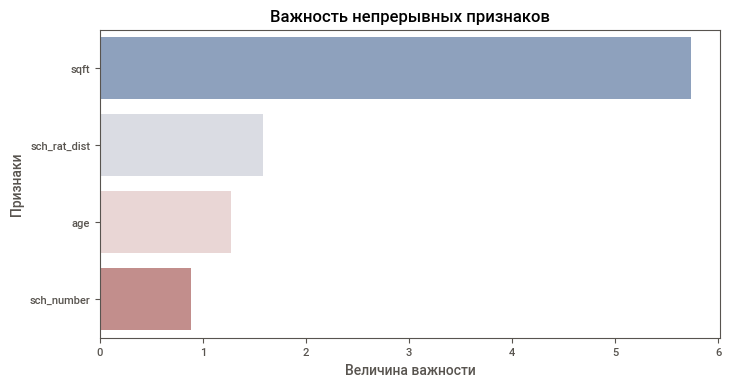

In [118]:
# Воспользуемся тестом ANOVA и проиллюстрируем его результаты
imp_num = pd.Series(f_classif(df[num_cols], df.target)[0], index = num_cols)
imp_num = imp_num.sort_values(ascending=False)

fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = imp_num.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность непрерывных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Хи-тест расположил признаки "propertyType_Land"и "stories_0 Stories" на 4-м и 5-м местах, а "in_st_capital" - выше середины рейтинга важности.  
Отметим также, что по результатам теста ANOVA, как и следовало ожидать, площадь недвижимости является наиглавшейним признаком среди остальных непрерывных с точки зрения влияния на стоимость объекта. А вот удаленность школ и их рейтинг оказались менее значимыми, чем год постройки и/или обновления объекта. Ну и количество школ поблизости играет наименьшую роль.   
Разделим df на обучающие и тестовые выборки (перед возможной нормализацией).  

In [119]:
# Разделяем датафрейм и готовим выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(212684, 30) (91151, 30) (212684,) (91151,)


### 5.12. Нормализация и стандартизация  

Эксперименты показали, что нормализация и стандартизация наших данных не дают прироста метрики, но даже несколько ухудшают ее. Поэтому обернем код в функции, чтобы при прогоне программы он не исполнялся, если только функции специально не будут вызваны. Такое решение представляется более лаконичным, чем закомментировать код.  

In [120]:
def mm_scaler(X_train: pd.DataFrame = X_train,
              X_test: pd.DataFrame = X_test) -> tuple:
    """Функция нормализует выборки с помощью MinMaxScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков для нормализации
    col_names = list(X_train.columns)

    # Создаем объект класса MinMaxScaler
    mm_scaler = MinMaxScaler()

    # Подгоняем нормализатор под тренировочную выборку
    mm_scaler.fit(X_train)

    # Нормализуем обе выборки
    X_train_scaled = mm_scaler.transform(X_train)
    X_test_scaled = mm_scaler.transform(X_test)

    # Преобразуем нормализованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

In [121]:
def s_scaler(X_train: pd.DataFrame = X_train,
             X_test: pd.DataFrame = X_test) -> tuple:
    """Функция стандартизирует выборки с помощью StandardScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков, которые будем стандартизировать
    col_names = list(X_train.columns)

    # Инициализируем стандартизатор StandardScaler
    s_scaler = StandardScaler()

    # Подгоняем стандартизатор под тренировочную выборку
    s_scaler.fit(X_train)

    # Стандартизуем обе выборки
    X_train_scaled = s_scaler.transform(X_train)
    X_test_scaled = s_scaler.transform(X_test)

    # Преобразуем стандартизованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

In [122]:
def r_scaler(X_train: pd.DataFrame = X_train,
             X_test: pd.DataFrame = X_test) -> tuple:
    """Функция нормализует выборки с помощью RobustScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков для нормализации
    col_names = list(X_train.columns)

    # Инициализируем нормализатор RobustScaler
    r_scaler = RobustScaler()

    # Подгоняем нормализатор под тренировочную выборку
    r_scaler.fit(X_train)

    # Нормализуем обе выборки
    X_train_scaled = r_scaler.transform(X_train)
    X_test_scaled = r_scaler.transform(X_test)

    # Преобразуем стандартизованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

___

## 6. Решение задачи регрессии  (Modeling)

В данном разделе мы применим различные модели машинного обучения с целью предсказания стоимости недвижимости. Будем обучать модели от простых к более сложным:  
- LinearRregression + PolynomialFeatures,  
- DecisionTreeRegressor,  
- RandomForestRegressor,  
- GradientBoostingRegressor,  
- StackingRegressor,   

Подбор гиперпараметров осуществим с помощью:  
- RandomizedSearchCV

В итоге сведем значения метрик в таблицу и выберем модель, которая лучше всех справилась с поставленной задачей.   


### 6.1. Улучшение baseline-результата  

Проверим, насколько разведывательный анализ оказался полезен в деле улучшения предсказания.  

In [123]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание и выведем результат
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 203902.54
MAPE на тренировочной выборке: 61.17
r2 на тренировочоной выборке: 0.46

MAE на тестовой выборке: 203287.64
MAPE на тестовой выборке: 60.85
r2 на тестовой выборке: 0.46


> Выводы по улучшению baseline:
>  
> 1) сразу после предварительной обработки модель показала `MAPE` = 84.66%, `R2` = 0.25 и абсолютную ошибку в \$250 тыс.  
>
> 2) генерирование новых признаков (в том числе путем десериализации), дополнительная обработка и очистка уже имевшихся улучшили целевую метрику почти в 2 раза: `R2` - до 0.46 или снижение абсолютной ошибки почти на $50 тыс.  
>
> 3) приблизились к показателям CatBoostRegressor (`MAPE` = 52%, `R2` = 0.57 и `MAE` = $173 тыс.)

### 6.2. Линейная регрессия с полиномиальными признаками  

Сгенерируем полиномиальные признаки 2-го порядка, чтобы проверить, сможет ли модель линейной регрессии лучше уловить закономерности в наших данных.  

In [124]:
# Создаем объект класса PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

# Генерируем полиномиальные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучим модель линейной регрессии на полиномиальных признаках
poly_model = LinearRegression()
%time poly_model.fit(X_train_poly, y_train)

# Выполним предсказание и выведем результат
y_train_pred = poly_model.predict(X_train_poly)
y_test_pred = poly_model.predict(X_test_poly)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1min 3s
Wall time: 17.3 s
MAE на тренировочоной выборке: 177097.39
MAPE на тренировочной выборке: 50.41
r2 на тренировочоной выборке: 0.56

MAE на тестовой выборке: 177809.85
MAPE на тестовой выборке: 50.37
r2 на тестовой выборке: 0.52


> Выводы по полиномиальной регрессии:
>
> Полиномиальная регрессия 2-го порядка улучшила метрики линейной регрессии: снижены `MAPE` и `MAE` но умеренное увеличение `R2`.  


### 6.2. Решающее дерево    

На эффективность работы модели оказывают влияние ее параметры, например: максимальная глубина дерева `max_depth`. Построим код, который позволит вручную перебрать несколько значений глубины и на графике отобразить изменений метрик качества.  

Далее, глядя на графики, мы определим оптимальную глубину дерева.  

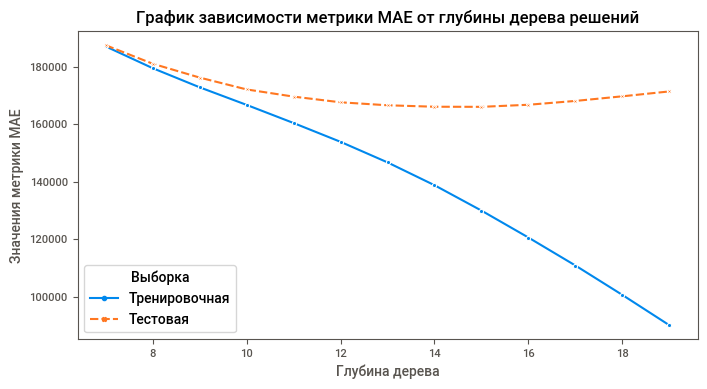

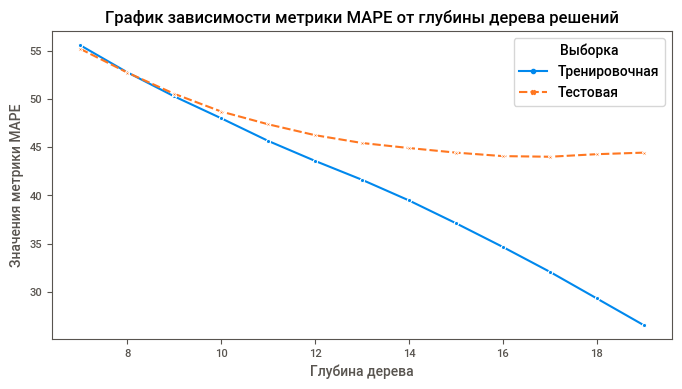

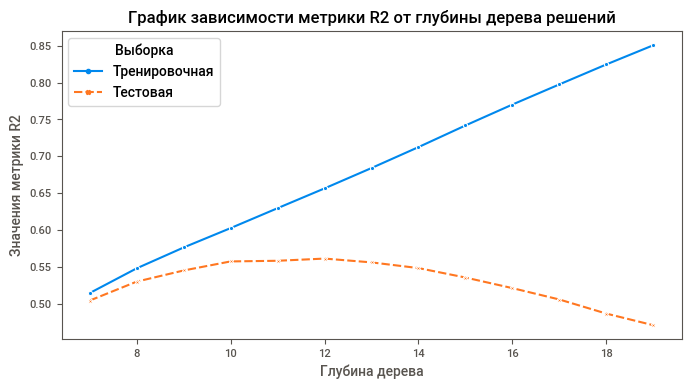

In [125]:
# Подготовим списки с глубиной дерева и для значений метрики
depths = list(np.arange(7, 20))
mae_train_score = []
mae_test_score = []
mape_train_score = []
mape_test_score = []
r2_train_score = []
r2_test_score = []

# Обучим модель с каждым значением глубины дерева и сохраним результаты
for d in depths:
    # Строим и обучаем модель дерева решений
    tree_reg = DecisionTreeRegressor(
        max_depth = d,
        random_state = 42)

    # Обучаем модель
    tree_reg.fit(X_train, y_train)

    # Выполняем предсказание
    y_train_pred = tree_reg.predict(X_train)
    y_test_pred = tree_reg.predict(X_test)

    # Вычисляем метрики качества
    mae_train, mape_train, r2_train, mae_test, mape_test, r2_test\
        = show_metrics(y_train, y_train_pred, y_test, y_test_pred, show = False)

    # Добавим значения метрик в списки
    mae_train_score.append(mae_train)
    mae_test_score.append(mae_test)
    mape_train_score.append(mape_train)
    mape_test_score.append(mape_test)
    r2_train_score.append(r2_train)
    r2_test_score.append(r2_test)


# Преобразуем получившиеся списки в датафреймы
mae_df = pd.DataFrame(
    data = {'Тренировочная': mae_train_score,
            'Тестовая': mae_test_score},
    index = depths)

mape_df = pd.DataFrame(
    data = {'Тренировочная': mape_train_score,
            'Тестовая': mape_test_score},
    index = depths)

r2_df = pd.DataFrame(
    data = {'Тренировочная': r2_train_score,
            'Тестовая': r2_test_score},
    index = depths)

# Построим линейный график зависимости MAE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mae_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики MAE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики MAE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости MAPE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mape_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики MAPE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики MAPE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости R2
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = r2_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики R2 от глубины дерева решений');
lineplot.set_ylabel('Значения метрики R2');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

Как видно на графике зависимости `MAE`, оптимальной глубина -  15, после чего метрика на тестовой выборке начинает расти, а тренировочная снижаться. Это говорит о переобучении модели.  
Кроме того, можно варьировать параметр минимального количества листьев в узле дерева `min_samples_leaf`, также влияя на результат.  

Обучим дерево с максимальной глубиной 15 и минимальным количеством листьев = 10 и увидим, как изменятся метрики. Зафиксируем, чтекущий результат при  глубине 15 на тестовых выборках:  
- `MAE`: 160206.83,  
- `MAPE`: 42.42%,  
- `R2`: 0.56.  

In [126]:
# Код для просмотра значений метрик при оптимальной глубине
opt_d=15
print('MAE:', mae_test_score[depths.index(opt_d)])
print('MAPE:', mape_test_score[depths.index(opt_d)])
print('R2:', r2_test_score[depths.index(opt_d)])

MAE: 166055.96386516994
MAPE: 44.44336908424176
R2: 0.5358377814020132


In [127]:
# Строим и обучаем модель дерева решений
tree_reg = DecisionTreeRegressor(
    max_depth = 15,
    min_samples_leaf = 10,
    random_state = 42)

# Обучаем модель
%time tree_reg.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = tree_reg.predict(X_train)
y_test_pred = tree_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 1.22 s
Wall time: 1.23 s
MAE на тренировочоной выборке: 148637.05
MAPE на тренировочной выборке: 40.49
r2 на тренировочоной выборке: 0.67

MAE на тестовой выборке: 164590.78
MAPE на тестовой выборке: 43.8
r2 на тестовой выборке: 0.58


>Выводы по модели решающего дерева:  
>
> Благодаря введению дополнительного параметра модели - минимального количества листьев, улучшены две из трех метрик: `MAPE` несколько ухудшилась, поскольку глубина 15 не была для нее оптимальной. Как, впрочем, и для `R2`, но тут доп. параметр нивелировал неоптимальное значение глубины.  

### 6.3. Случайный лес и оптимизация гиперпараметров  

Вопользуемся алгоритмом RandomizedSearchCV.  

In [128]:
# Создаем сетку перебираемых параметров
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': np.arange(11, 18, 2),
    'min_samples_leaf': [5, 10, 15]
}

# Создаем модель RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator = RandomForestRegressor(
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    param_distributions = param_distributions,
    cv = 2,
    scoring = 'r2',
    return_train_score = False,
    n_jobs = -1,
    verbose = 1
)

# Обучим модель
%time rand_search.fit(X_train, y_train)

# Сделаем предсказания
y_train_pred = rand_search.predict(X_train)
y_test_pred = rand_search.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: total: 11min 14s
Wall time: 8min 55s
MAE на тренировочоной выборке: 130726.09
MAPE на тренировочной выборке: 36.33
r2 на тренировочоной выборке: 0.75

MAE на тестовой выборке: 152499.39
MAPE на тестовой выборке: 41.29
r2 на тестовой выборке: 0.64


In [129]:
# Выведем подобранные значения гиперпараметров, использованные для прогноза
print('Наилучшие значения гиперпараметров:', rand_search.best_params_)

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 17}


>Выводы по модели случайного леса: 
>
> Фактор времени обучения модели играет свою роль. В данном случае решающее влияние оказал алгоритм случайного перебора гиперпараметров. Зафиксируем оптимальные гиперпараметры

### 6.4. Градиентный бустинг над деревьями решений  

Градиентный бустинг использует относительно слабые модели, которые последовательно пытаются улучшить ошибку предыдущих. В градиентном бустинге базовой моделью являются деревья решений.  

In [130]:
# Строим модель градиентного бустинга
boo_reg = GradientBoostingRegressor(
    learning_rate = 0.1,
    n_estimators = 100,
    max_depth = 15,
    min_samples_split = 20,
    random_state = 42
)

# Обучаем модель
%time boo_reg.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = boo_reg.predict(X_train)
y_test_pred = boo_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 2min 9s
Wall time: 2min 9s
MAE на тренировочоной выборке: 100956.41
MAPE на тренировочной выборке: 29.16
r2 на тренировочоной выборке: 0.86

MAE на тестовой выборке: 147171.86
MAPE на тестовой выборке: 39.29
r2 на тестовой выборке: 0.65


>Выводы по модели градиентного бустинга:
>
> Последовательное уменьшение ошибки меньшим количеством деревьев, принесло лучшие результаты, чем бОльшее число деревьев в случайном лесу: `R2` = 0.69, `MAPE` = 36%.    
> Когда мы использовали более широкие границы в методе z-отклонений (3 почти для всех типов недвижимости) при выявлении выбросов в признаке "target", удалось получить максимальное значение `R2` = 0.7 на тестовой выборке, но  `MAPE` снизилось до 40%. Это означает, что хотя модель и лучше уловила зависимости в данных, но не удаленные выбросы спровоцировали ошибки. Выясним, какие признаки оказались наиболее значимыми.    

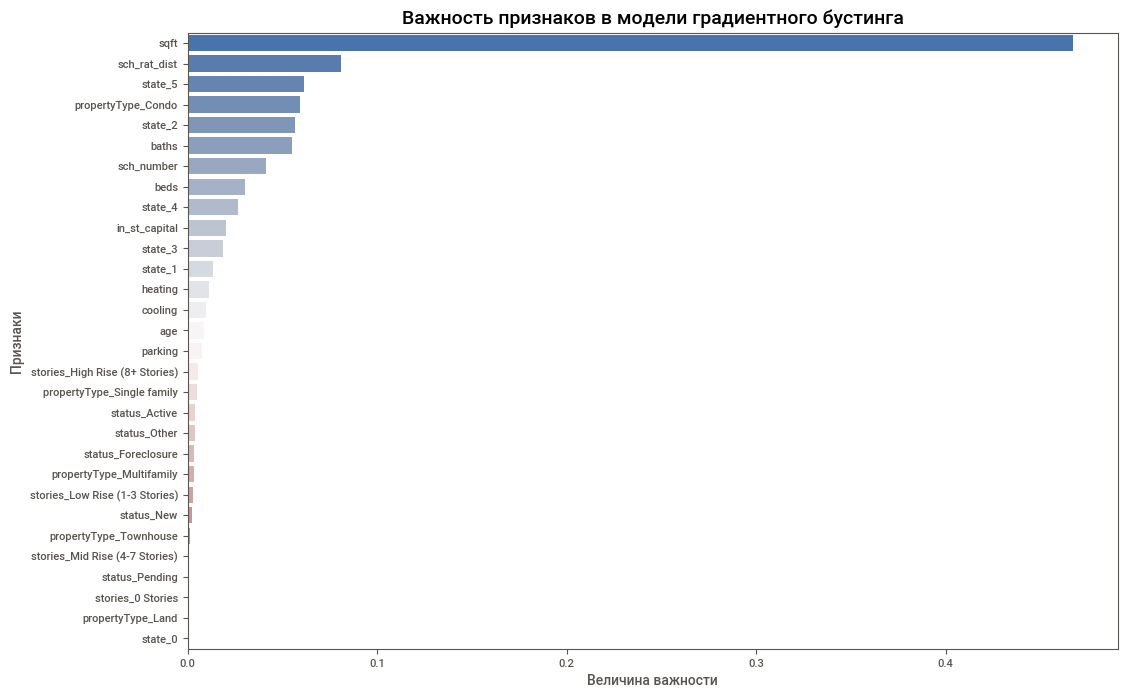

In [131]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
gb_feat = pd.Series(boo_reg.feature_importances_,
                    index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Площадь объекта недвижимости "sqft" - стала самым важным признаком. А вот признак "status Foreclosure", который был определен тестом хи-квадрат как наиболее важный среди категориальных признаков, опустился в самый низ рейтинга

Скорее всего, что на результаты градиентного бустинга не повлияло бы, если бы мы все-таки удалили признаки "stories_0 Stories" и "propertyType_Land", на которые нам указывал SelectKBest.  
Ожидаемо, что покупателям важен возраст недвижимости (2-е место). Количество ванных комнат интересует будущих жильцов гораздо больше, чем количество спален. Между ванными и спальнями расположился признак количества школ в окрестности.

### 6.5. Стэкинг моделей  

Объединим три модели с помощью стекинга и выясним, удастся ли достичь более высоких результатов.В стекинге модели обучаются независимо друг от друга, а их предсказания служат для обучения метамодели.  

In [132]:
# Создаем список моделей для стекинга с подобранными ранее параметрами
estimators = [
    ('dt', DecisionTreeRegressor(
        max_depth = 15,
        min_samples_leaf = 10,
        random_state = 42)
    ),
    ('rf', RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42)
    ),
    ('gb', GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 100,
        max_depth = 15,
        min_samples_split = 20,
        random_state = 42)
    )
]

# Создаем объект класса стекинг
stack_reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    cv = 2,
    n_jobs = -1,
    verbose = 5
)

# Обучаем модель
%time stack_reg.fit(X_train, y_train)

# Делаем предсказание
y_train_pred = stack_reg.predict(X_train)
y_test_pred = stack_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: total: 3min 53s
Wall time: 4min 56s
MAE на тренировочоной выборке: 112308.22
MAPE на тренировочной выборке: 31.26
r2 на тренировочоной выборке: 0.81

MAE на тестовой выборке: 148645.28
MAPE на тестовой выборке: 39.54
r2 на тестовой выборке: 0.65


>Выводы по модели стеккинга:  
>
> Три независимые модели не улучшили показатели. `MAPE` осталась на том же уровне, `MAE` ухудшилась на $2 тыс., а `R2` снизилась на 0.01.  Таким образом, лидирует градиентный бустинг.

> Общий вывод по 6-му разделу (Evaluation):
>
> Сведем в таблицу все полученные результаты, чтобы проще было оценить эффективность тех или иных моделей.  


| Модель | R2 | MAPE | MAE |  
|---|---:|---:|---:|   
| LinearRegression | 0.46 | 61.20  | 202873.48 |  
| PolynomialRegression | 0.47 | 49.75 | 174529.22  |  
| DecisionTreeRegressor | 0.59 | 42.37 | 159516.00 |  
| RandomForestRegressor | 0.67 | 38.95 | 143491.40 |  
| **GradientBoostingRegressor** | **0.69** | **36.06** | **135979.72** |  
| StackingRegressor | 0.68 | 36.31 | 137896.81 |  


  
>
> Из таблицы видно, как с возрастанием сложности моделей и алгоритмов растут и результаты. Модель градиентного бустинга оказалась наиболее успешной, и именно ее используем в продакшене на следующем этапе. 

## 7. Подготовка модели к продакшену (Preparation for deployment)   

С помощью библиотеки Pickle сериализуем обученную модель градиентного бустинга и сохраним ее в файл. Его останется только открыть и развернуть на сервере, чтобы выполнять прогнозы стоимости недвижимости.  

Для проверки корректности работы модели, развернутой на сервере, ниже приводится предсказание на тестовом наборе (состоящем из одной записи из выборки X_test). Точно такой же набор будет подан на сервер клиентским приложением. Ответ должен совпасть.  

Важное замечание: при подаче тестового набора в модель, развернутую на сервере возникает предупреждение о том, что данные представлены вектором, а модель обучена на DataFrame с названиями столбцов. Для устранения этого некритичного, но неприятного предупреждения мы заново обучили модель градиентного бустинга на значениях (values) тренировочной выборки (не показано в ноутбуке).

In [133]:
# Производим сериализацию модели и сохраняем ее в файл формата pkl
with open('data.csv'+'p7model.pkl', 'wb') as output:
    pickle.dump(boo_reg, output)

In [134]:
# Задаем тестовый набор
test_data = [2,1820,3,1,0,1,4,7,3,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1]
test_data = np.array(test_data).reshape(1, -1) # преобразуем в датафрейм

# Выполняем предсказание с помощью обученной модели
prediction = boo_reg.predict(test_data)

# Выводим результат на экран для проверки при запуске на сервере
print('Такое предсказание должен вернуть сервер:', round(prediction[0]))

Такое предсказание должен вернуть сервер: 382224


___

## 8. Выводы по проекту  

1. Все задачи, поставленные в проекте  - выполнены. Работая над проектом, пройдены все этапы модели CRISP-DM.  
2. Достигнутые результаты поучены за счет многократного возвращения к предыдущим этапам очистки и подготовки данных, после получения первых результатов, создания новых признаков, изменения критериев фильтрации записей и отбора признаков.  
3. В качестве возможных шагов повышения качества моделирования, стоит уделить больше времени подготовке данных, например:  
    - разделить на большее количество категорий типы недвижимости,  
    - выделить ценовые категории недвижимости,  
    - применить алгоритмы кластеризации для выделения групп жилья по иным критериям,   
    - добавить в df новые данные на основании признака "street" (близость ТРЦ, автозаправок, автострад, аэропортов, больниц и т.д.). 
4. В общем проект позволил применить все знания и навыки, полученные за время обучения на курсе.


___